# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import defaultdict
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve
from itertools import compress
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

'''
TODO:

1. Try to improve

2. Desing the replace_val for each column

3. Creat preprocess procedure for every class.
'''


%matplotlib inline

rs = 101

 # Task 1. Data Selection and Distribution. 

In [2]:
## Read Data
df = pd.read_csv("CaseStudyData.csv")

 ### 1. What is the proportion of cars who can be classified as a “kick”? 

In [3]:
## Exploring the features in this dataset
print("Number of Columns: ", len(df.columns))
print("Columns: ",list(df.columns))

Number of Columns:  31
Columns:  ['PurchaseID', 'PurchaseTimestamp', 'PurchaseDate', 'Auction', 'VehYear', 'Make', 'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size', 'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'PRIMEUNIT', 'AUCGUART', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'ForSale', 'IsBadBuy']


In [4]:
print("Number of Observations: ", len(df))

Number of Observations:  41476


In [5]:
proportionOfKicks = len(df[df['IsBadBuy'] == 1]) / len(list(df['IsBadBuy']))
print("The proportion of kicks: ", proportionOfKicks)

The proportion of kicks:  0.1294965763333012


### 2. Did you have to fix any data quality problems? Detail them.

In [6]:
#### PREPROCESSING STATEGY
NEW_STATEGY = True
ResamplingMethod = 'ros' #['ros', 'rus']
if NEW_STATEGY:
    print("Using New Preprocessing Strategy")
    using_cat = False
    categorial_cols = ['Auction', 'VehYear', 'Make', 'Color', 'Transmission','WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName','PRIMEUNIT','AUCGUART','VNST','IsOnlineSale','ForSale' ] # Replaced by the most common 
    interval_cols = ['VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','VehBCost','WarrantyCost' ] 
    drop_cols = ['PurchaseID','PurchaseDate','PurchaseTimestamp']
    questionMark_data = ['MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio']
    replaced_vals = ['?', '#VALUE!']
    if using_cat:
        categorial_cols += questionMark_data
        print("See [MMRCurrentAuctionAveragePrice" +
              "MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice," +
              " MMRCurrentRetailCleanPrice, MMRCurrentRetailRatio] as Categorial Data")
    else: 
        interval_cols += questionMark_data
        print("See [MMRCurrentAuctionAveragePrice" +
              "MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice," +
              " MMRCurrentRetailCleanPrice, MMRCurrentRetailRatio] as Interval Data")
else:
    print("Using Old Preprocessing Strategy")
    drop_cols = ['PurchaseID','PurchaseDate']
    categorial_cols = ['Auction', 'VehYear', 'Make', 'Color', 'Transmission','WheelTypeID', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName','PRIMEUNIT','AUCGUART','VNST','IsOnlineSale','ForSale' ] # Replaced by the most common 
    interval_cols = ['PurchaseTimestamp', 'VehOdo','MMRAcquisitionAuctionAveragePrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice','MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio','VehBCost','WarrantyCost' ] # Replaced by the mean
    replaced_vals = ['?', '#VALUE!']

print("Total null before Replacing: ", df.isnull().sum().sum())

Using New Preprocessing Strategy
See [MMRCurrentAuctionAveragePriceMMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice, MMRCurrentRetailCleanPrice, MMRCurrentRetailRatio] as Interval Data
Total null before Replacing:  1691


In [7]:
def printColumnInfo():
    
    '''
    Display the information of this Dataframe
    '''
    
    for colName in df.columns:
        print("======================= " + str(colName) + " =======================")
        print("----------------------- FIRST FIVE -----------------------")
        print(df[colName][:5])
        print("----------------------- DESCIRBE -----------------------")
        print(df[colName].describe())
        print("----------------------- COUNTS -----------------------")
        commonList = list(df[colName].value_counts().keys())
        if len(commonList) > 100:
            print("Five Most Common: ", commonList[:5])
        else:
            print("Count List: \n", df[colName].value_counts())
        print("Num of NULL: ", df[colName].isnull().sum())
        for rep in replaced_vals:
            print("Number of "+str(rep)+" : " + str(len(df[df[colName] == rep])))
printColumnInfo()

======================= PurchaseID =======================
----------------------- FIRST FIVE -----------------------
0    0
1    1
2    2
3    3
4    4
Name: PurchaseID, dtype: int64
----------------------- DESCIRBE -----------------------
count    41476.000000
mean     20737.500000
std      11973.234219
min          0.000000
25%      10368.750000
50%      20737.500000
75%      31106.250000
max      41475.000000
Name: PurchaseID, dtype: float64
----------------------- COUNTS -----------------------
Five Most Common:  [2047, 11567, 15693, 13644, 3403]
Num of NULL:  0
Number of ? : 0
Number of #VALUE! : 0
======================= PurchaseTimestamp =======================
----------------------- FIRST FIVE -----------------------
0    1253232000
1    1253232000
2    1253232000
3    1253232000
4    1253232000
Name: PurchaseTimestamp, dtype: int64
----------------------- DESCIRBE -----------------------
count    4.147600e+04
mean     1.262260e+09
std      1.796895e+07
min      1.231114e+09


Number of ? : 3
Number of #VALUE! : 0
======================= TopThreeAmericanName =======================
----------------------- FIRST FIVE -----------------------
0    CHRYSLER
1    CHRYSLER
2    CHRYSLER
3          GM
4    CHRYSLER
Name: TopThreeAmericanName, dtype: object
----------------------- DESCIRBE -----------------------
count     41432
unique        5
top          GM
freq      14075
Name: TopThreeAmericanName, dtype: object
----------------------- COUNTS -----------------------
Count List: 
 GM          14075
CHRYSLER    13627
FORD         7039
OTHER        6688
?               3
Name: TopThreeAmericanName, dtype: int64
Num of NULL:  44
Number of ? : 3
Number of #VALUE! : 0
======================= MMRAcquisitionAuctionAveragePrice =======================
----------------------- FIRST FIVE -----------------------
0    8566
1    8566
2    8835
3    7165
4    8566
Name: MMRAcquisitionAuctionAveragePrice, dtype: object
----------------------- DESCIRBE -----------------------
c

In [8]:
if NEW_STATEGY:

    class filling_method():
        MOST_COMMON = "MOST_COMMON"
        MEAN = "MEAN"
        CERTAIN_VALUE = "CERTAIN_VALUE"

    def replaceFunc(colName):
        for replaced, target in preprocessStrategy[colName]['replace_pairs']:
            df[colName].replace(replaced, target, inplace=True)

    def removeOutlier(colName):  # FOR THE INTERVAL ONLY
        global df
        df = df[df[colName] < df[colName].quantile(0.999)]

    def replacingValueCol(colName):
        for replaced in preprocessStrategy[colName]['replaced_vals']:
            print("In the Column: " + str(colName) + " : " + str(len(
                df[df[colName] == replaced])) + ", " + str(replaced) + "have been replaced by null")
            # Replacing the null in this process #Inplacing for saving the memory
            df[colName].replace(replaced, float('nan'), inplace=True)

    def loweringCol(colName):
        df[colName] = df[colName].str.lower()

    def fillingTheNullValue(colName):  # method can be ["MEAN", "MOST_COMMON"]
        if preprocessStrategy[colName]['filling_method'] == filling_method.MEAN:
            df[colName] = df[colName].astype('float')
            df[colName].fillna(df[colName].astype(
                'float').mean(), inplace=True)
        elif preprocessStrategy[colName]['filling_method'] == filling_method.MOST_COMMON:
            df[colName] = df[colName].astype('category')
            df[colName].fillna(df[colName].astype(
                'category').describe()['top'], inplace=True)
        elif preprocessStrategy[colName]['filling_method'] == filling_method.CERTAIN_VALUE:
            df[colName] = df[colName].astype('category')
            df[colName] = df[colName].cat.add_categories(
                [preprocessStrategy[colName]['filling_value']])
            df[colName].fillna(preprocessStrategy[colName]
                               ['filling_value'], inplace=True)

    def filterOutRareValue(colName):

        def checkingKeepValue(v, savingValues):
            if v in savingValues:
                return v
            return "LESS_FREQ"

        k = [v for v in df[colName].value_counts().values if v >
             preprocessStrategy[colName]['min_freq']]
        savingValues = df[colName].value_counts().keys()[:len(k)]

        df[colName] = [checkingKeepValue(v, savingValues) for v in df[colName]]

    def changeToType(colName):
        df[colName] = df[colName].astype(
            preprocessStrategy[colName]['changeToType'])

    def newData_prep(df):
        '''
        For Preprocessing through the whole dictionary
        '''
        df.drop(drop_cols, axis=1, inplace=True)

        for colName in df.columns:  # df.columns:

            print("Preprocess the col: " + colName)

            for stra in preprocessStrategy[colName]['strategies']:
                if not stra:
                    continue
                stra(colName)

        if not using_cat:
            df['MMRCurrentRetailRatio'] = df['MMRCurrentRetailAveragePrice'] / \
                (df['MMRCurrentRetailCleanPrice']+1e-8)  # Prvent divided by 0

        return df

    preprocessStrategy = defaultdict(dict)

    preprocessStrategy['Auction'] = {
        "strategies":
            [
                replacingValueCol,
                loweringCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['VehYear'] = {
        "strategies":
            [
                fillingTheNullValue,
            ],
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": "UNKNOWN_VALUE"
    }

    preprocessStrategy['Make'] = {
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['Color'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['Transmission'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['WheelTypeID'] = {
        "strategies":
            [
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['WheelType'] = {
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['VehOdo'] = {
        "strategies":
            [
                fillingTheNullValue,
            ],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['Nationality'] = {  # Should I merge USA with AMERICAN?
        "strategies":
            [
                replaceFunc,
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON,
        "replace_pairs": [("USA", "AMERICAN")]

    }

    preprocessStrategy['Size'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON

    }

    preprocessStrategy['TopThreeAmericanName'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['TopThreeAmericanName'] = {
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MOST_COMMON
    }

    preprocessStrategy['MMRAcquisitionAuctionAveragePrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['MMRAcquisitionAuctionCleanPrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['MMRAcquisitionRetailAveragePrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['MMRAcquisitonRetailCleanPrice'] = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],
        "filling_method": filling_method.MEAN
    }

    ###############################################################

    int_stra = {
        "strategies":
            [
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?', '#VALUE!'],  # GOT 184 '?'
        "filling_method": filling_method.MEAN,
    }

    cat_stra = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                filterOutRareValue,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
        "min_freq": 50
    }

    preprocessStrategy['MMRCurrentAuctionAveragePrice'] \
        = preprocessStrategy['MMRCurrentAuctionCleanPrice'] \
        = preprocessStrategy['MMRCurrentRetailAveragePrice'] \
        = preprocessStrategy['MMRCurrentRetailCleanPrice'] \
        = preprocessStrategy['MMRCurrentRetailRatio'] \
        = cat_stra if using_cat else int_stra

    ###############################################################

    preprocessStrategy['PRIMEUNIT'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
    }

    preprocessStrategy['AUCGUART'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
    }

    preprocessStrategy['VNST'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                fillingTheNullValue,
            ],
        #     "replaced_vals": ['?'], # GOT 184 '?'
        "filling_method": filling_method.CERTAIN_VALUE,
        "filling_value": 'NULL',
    }

    preprocessStrategy['VehBCost'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                replacingValueCol,

                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],  # GOT 184 '?'
        "filling_method": filling_method.MEAN
    }

    preprocessStrategy['IsOnlineSale'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                replacingValueCol,
                changeToType,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?', 2.0, 4.0],  # GOT 184 '?'
        "filling_method": filling_method.MOST_COMMON,
        "changeToType": 'float'
    }

    preprocessStrategy['WarrantyCost'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                fillingTheNullValue,
            ],
        "replaced_vals": ['?'],  # GOT 184 '?'
        "filling_method": filling_method.MEAN,
    }

    preprocessStrategy['ForSale'] = {  # HOW DO WE DEAL WITH ? in this column
        "strategies":
            [
                loweringCol,
                replacingValueCol,
                fillingTheNullValue,
            ],
        "replaced_vals": ['?', 0],  # GOT 184 '?'
        "filling_method": filling_method.MOST_COMMON,
    }

    # HOW DO WE DEAL WITH ? in this column
    preprocessStrategy['IsBadBuy'] = {"strategies": [None]}

    newData_prep(df)


else:

    def data_prep(df):
        '''
        For Preprocessing the Data (OLD_METHOD)
        '''

        # Check the replaced values are not in the dataset

        for colName in df.columns:

            if colName in categorial_cols:

                if colName == "IsOnlineSale":
                    df[colName] = df[colName].astype(
                        'float').astype('category')
                    df[colName].fillna(df[colName].astype(
                        'category').describe()['top'], inplace=True)

                # Try to lower the data if the data type is string
                try:
                    df[colName] = df[colName].str.lower()
                except:
                    print(colName, " can't be lowered")

                for replaced in replaced_vals:
                    print("In the Column: " + str(colName) + ": " +
                          str(len(df[df[colName] == replaced])) + " -> " + str(replaced))
                    df[colName].replace(replaced, float('nan'), inplace=True)

                df[colName] = df[colName].astype('category')

                # Replacing the null by the most common category
                df[colName].fillna(df[colName].astype(
                    'category').describe()['top'], inplace=True)

            if colName in interval_cols:

                if colName == "MMRCurrentRetailRatio":  # Dealing with this calculated value at the last
                    continue

                for replaced in replaced_vals:
                    print("In the Column: " + str(colName) + ": " +
                          str(len(df[df[colName] == replaced])) + " -> " + str(replaced))
                    df[colName].replace(replaced, float('nan'), inplace=True)

                df[colName] = df[colName].astype('float')

                # Removing outlier
                df = df[df[colName] < df[colName].quantile(0.999)]

                # Replacing the null by the mean
                df[colName].fillna(df[colName].astype(
                    'float').mean(), inplace=True)

        df['MMRCurrentRetailRatio'] = df['MMRCurrentRetailAveragePrice'] / \
            (df['MMRCurrentRetailCleanPrice']+1e-8)  # Prvent divided by 0

        df.drop(drop_cols, axis=1, inplace=True)

        return df

    df = data_prep(df)


Preprocess the col: Auction
In the Column: Auction : 0, ?have been replaced by null
Preprocess the col: VehYear
Preprocess the col: Make
Preprocess the col: Color
In the Column: Color : 6, ?have been replaced by null
Preprocess the col: Transmission
In the Column: Transmission : 6, ?have been replaced by null
Preprocess the col: WheelTypeID
Preprocess the col: WheelType
Preprocess the col: VehOdo
Preprocess the col: Nationality
In the Column: Nationality : 3, ?have been replaced by null
Preprocess the col: Size
In the Column: Size : 3, ?have been replaced by null
Preprocess the col: TopThreeAmericanName
In the Column: TopThreeAmericanName : 3, ?have been replaced by null
Preprocess the col: MMRAcquisitionAuctionAveragePrice
In the Column: MMRAcquisitionAuctionAveragePrice : 7, ?have been replaced by null
Preprocess the col: MMRAcquisitionAuctionCleanPrice
In the Column: MMRAcquisitionAuctionCleanPrice : 7, ?have been replaced by null
Preprocess the col: MMRAcquisitionRetailAveragePrice

### 3. Can you identify any clear patterns by initial exploration of the data using histogram or box plot?

In [9]:
def plotAllCols (df):
    for colName in df.columns:
        plt.figure(figsize=(20,10))
        if colName in categorial_cols:
            ### if it's categorial column, plot hist diagram 
            sns.countplot(x=colName, data = df, hue="IsBadBuy")
        elif colName in interval_cols:
            ### if it's interval column, plot box diagram
            sns.boxplot(x="IsBadBuy", y=colName, data = df )

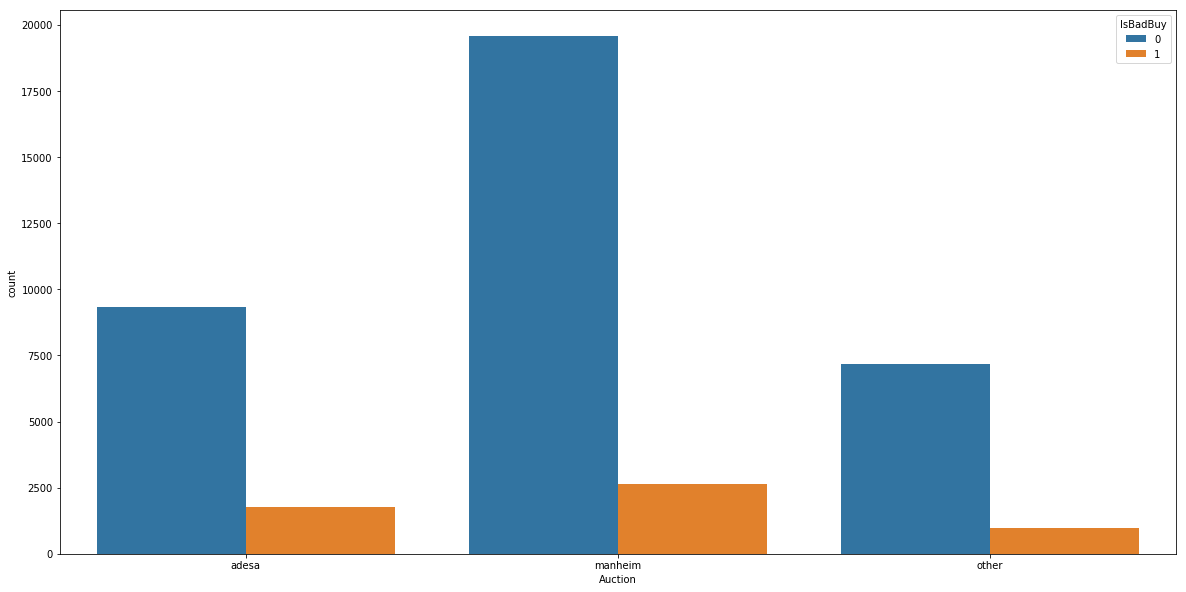

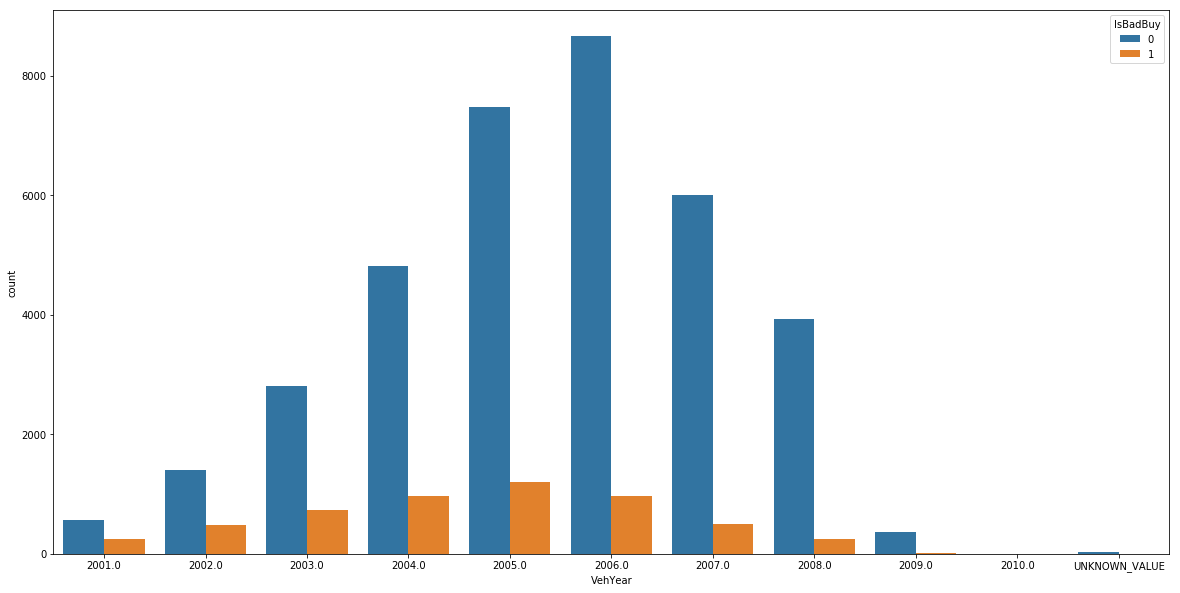

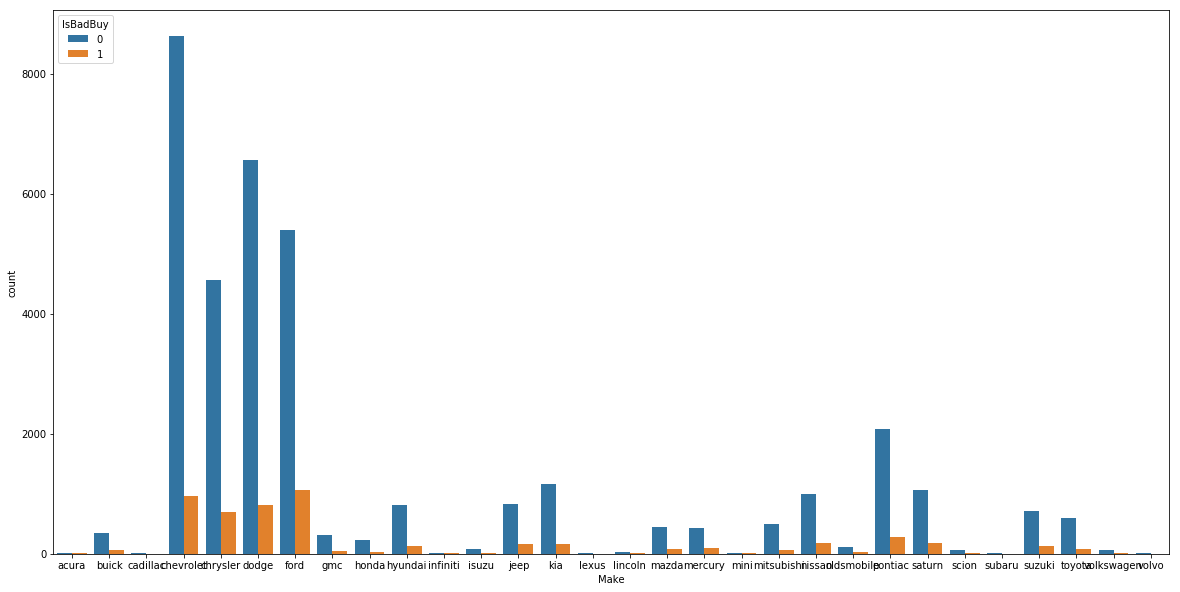

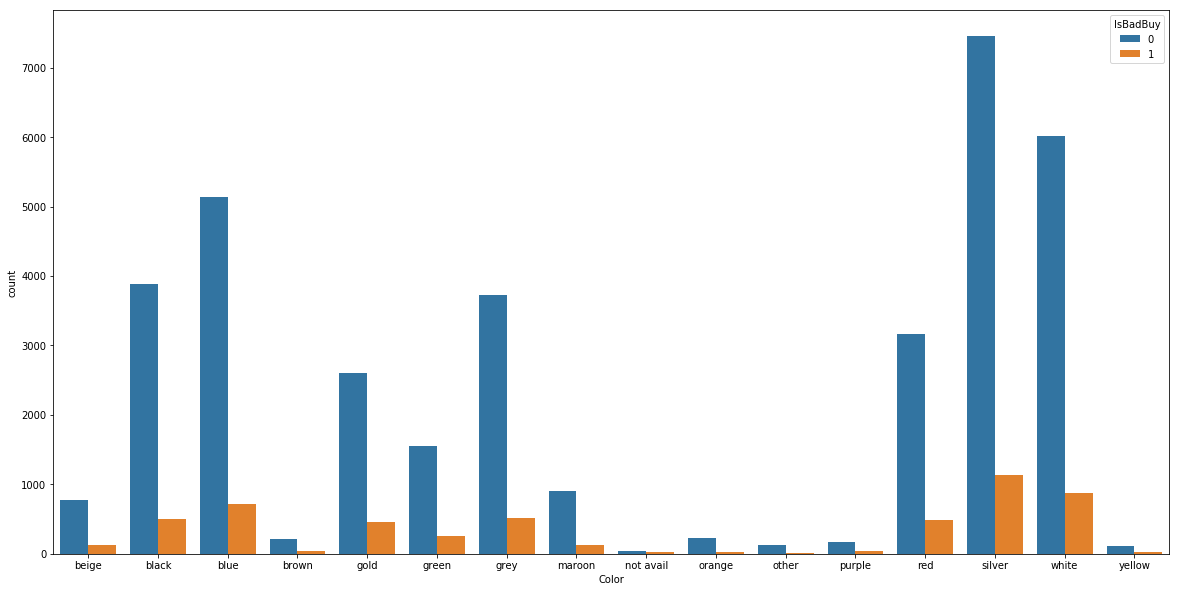

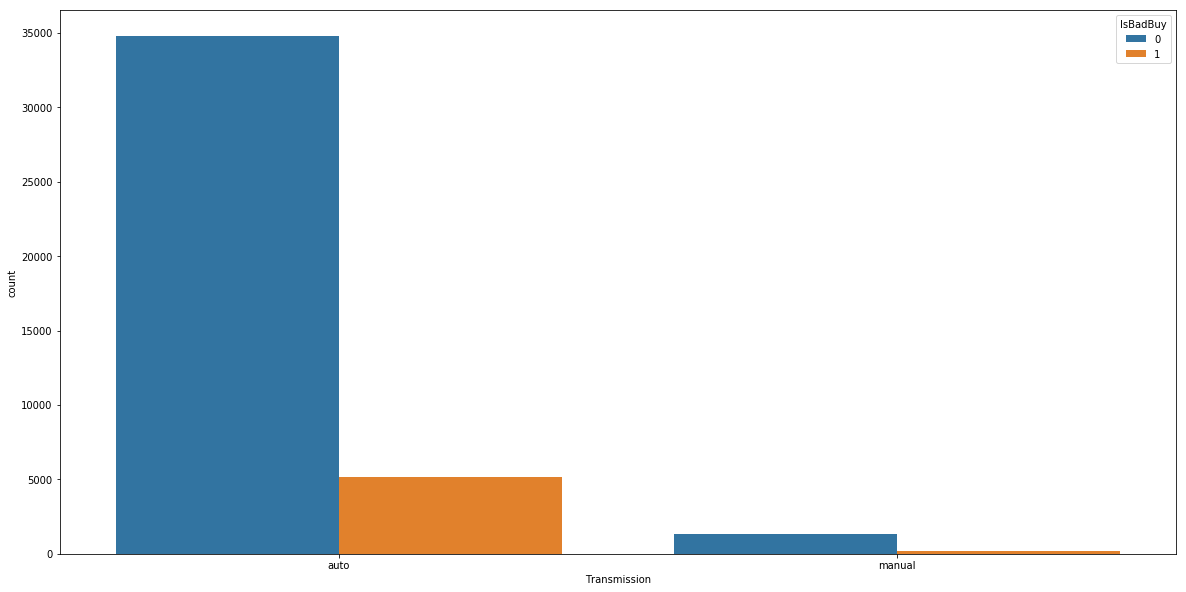

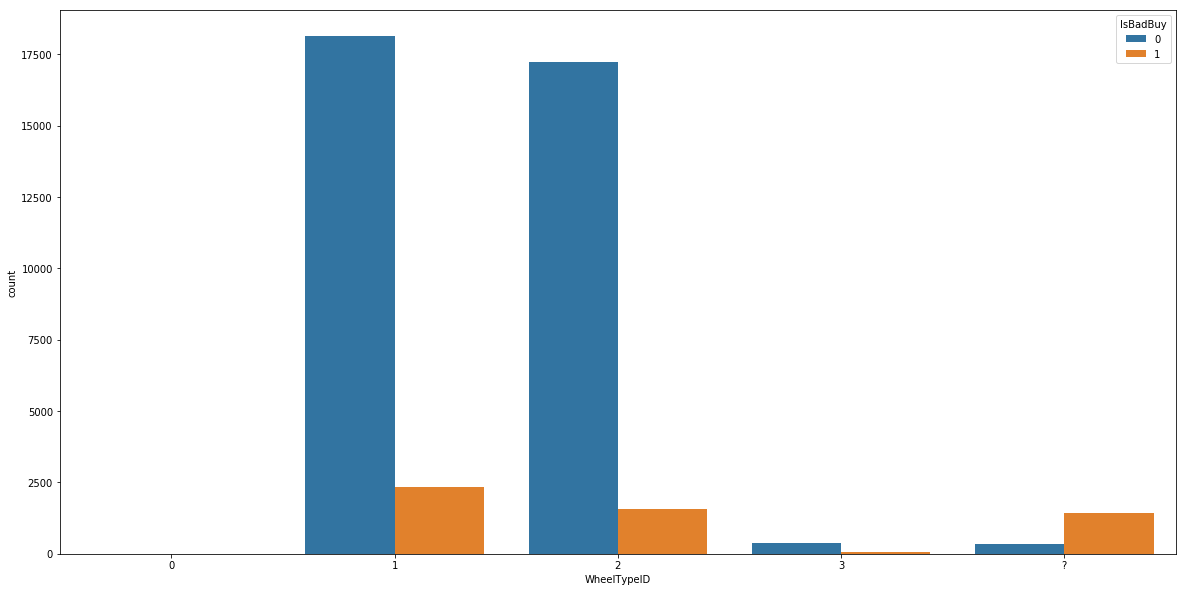

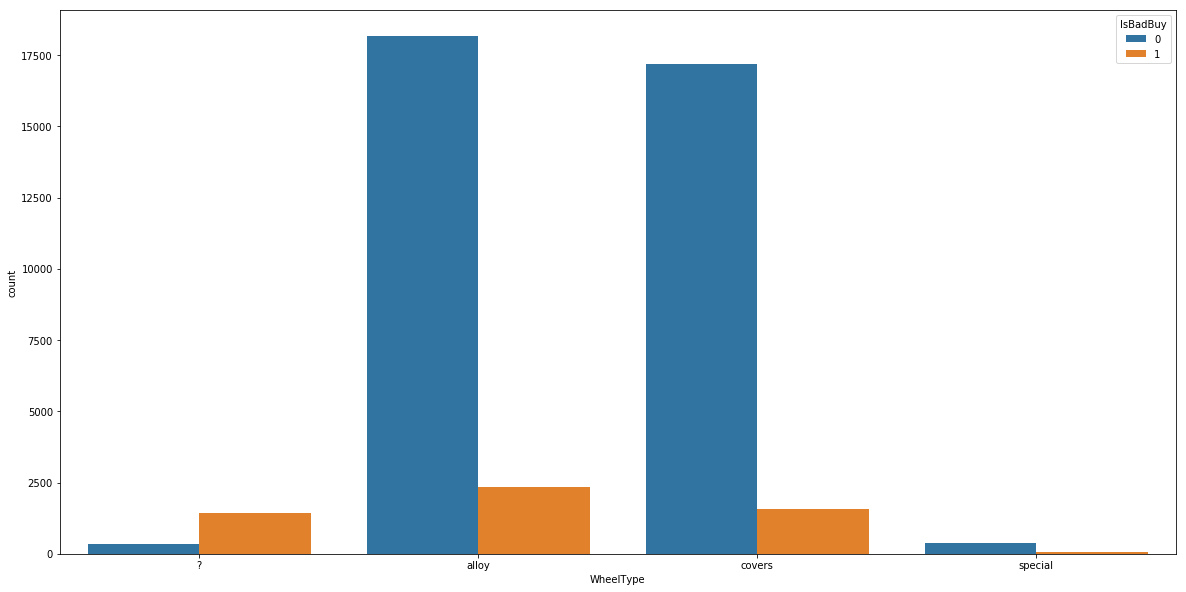

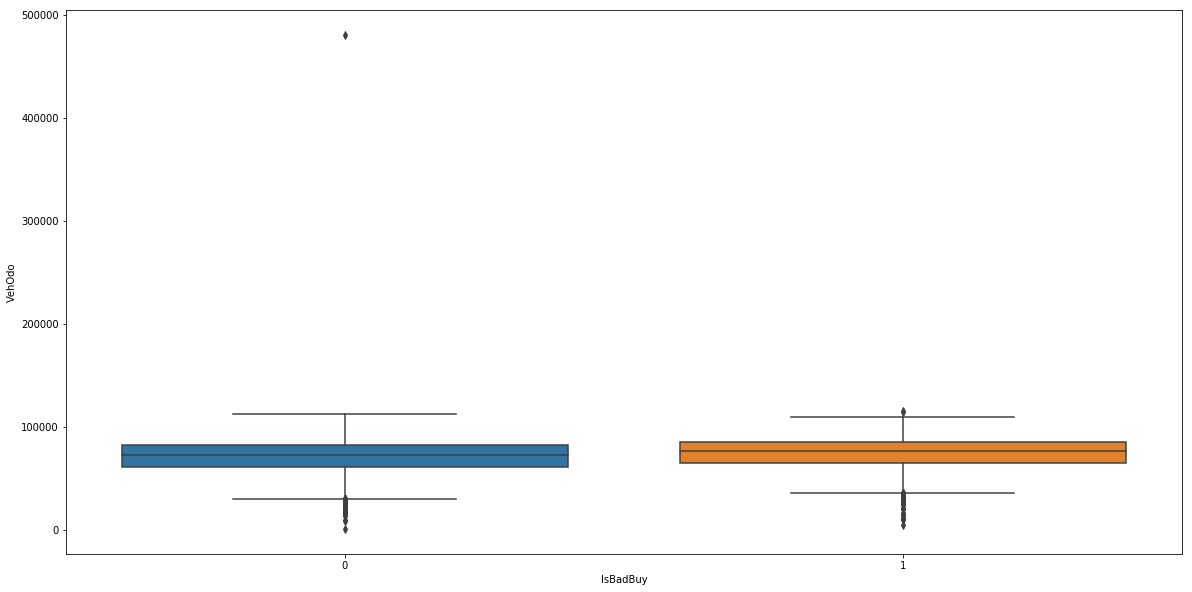

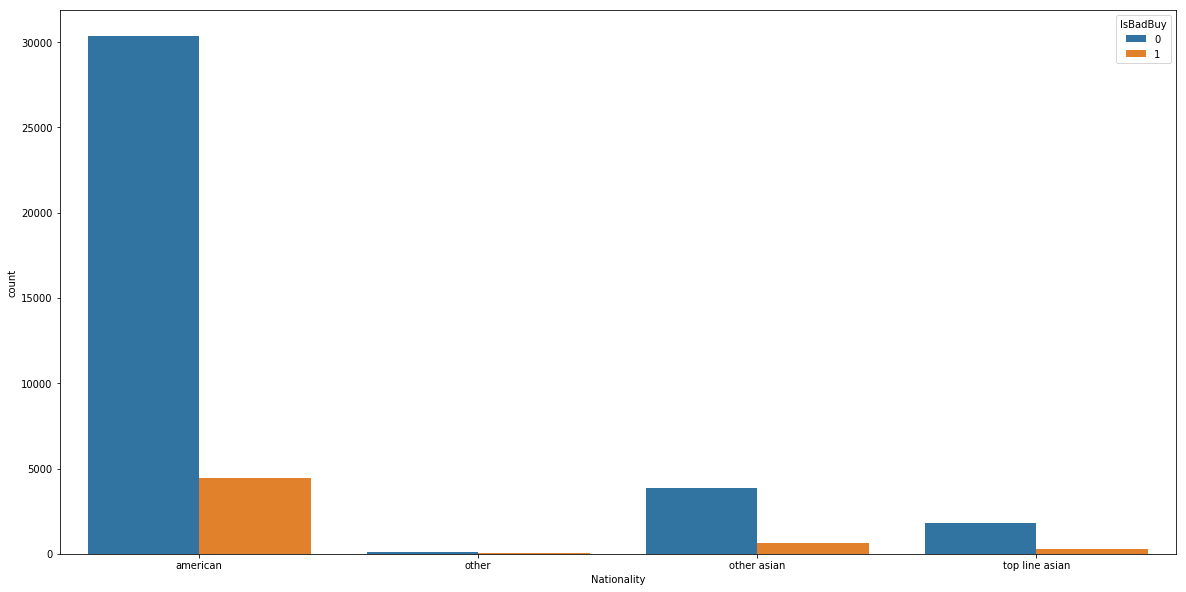

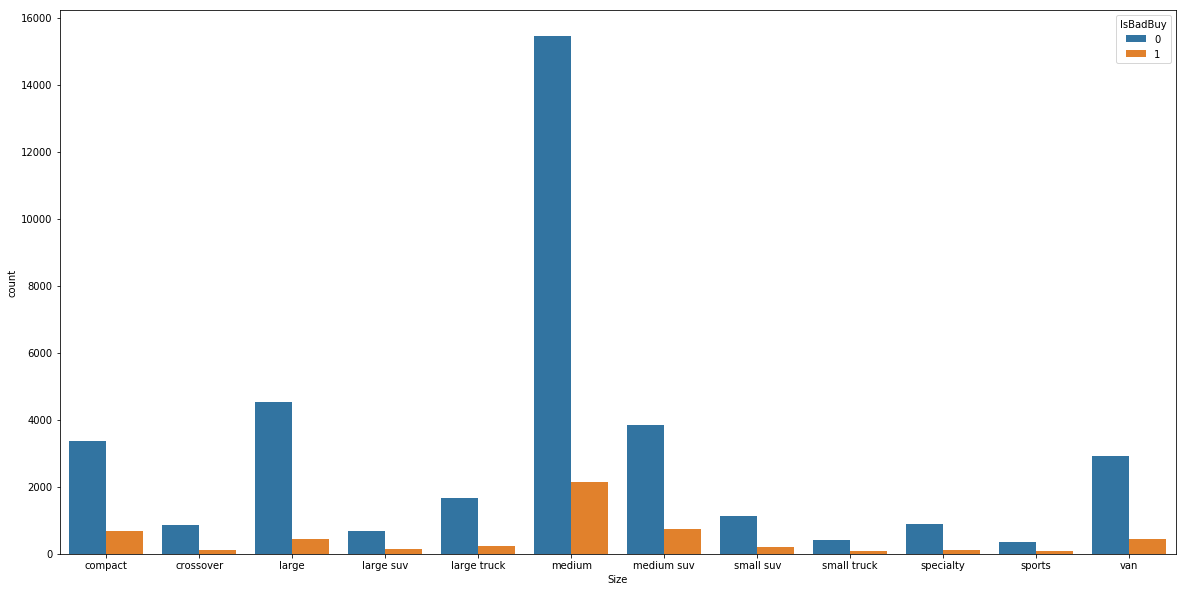

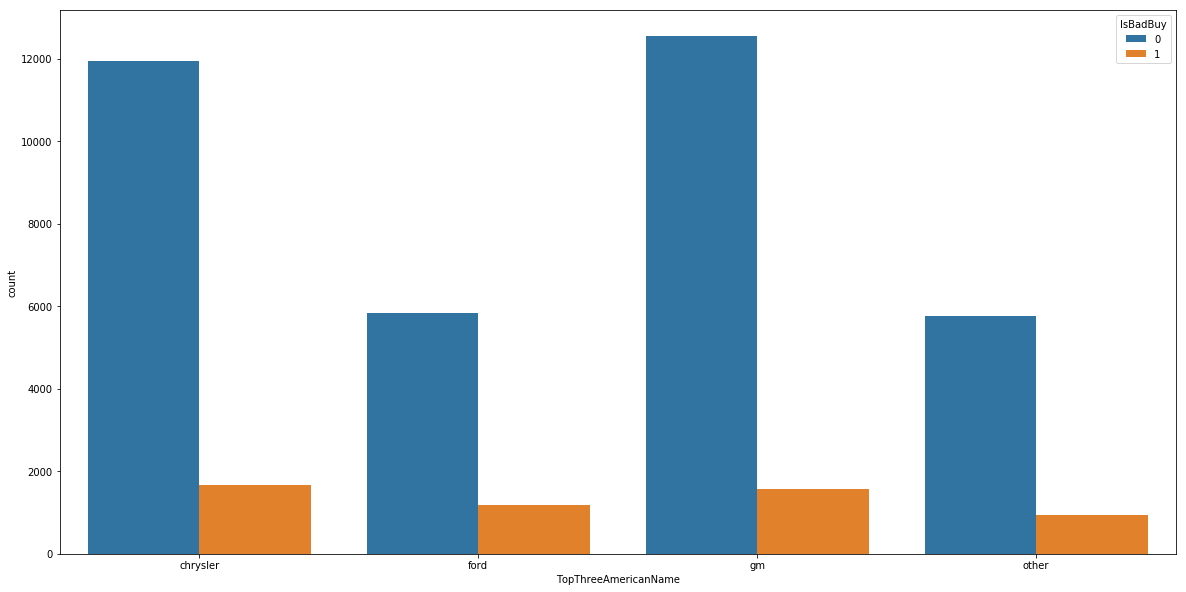

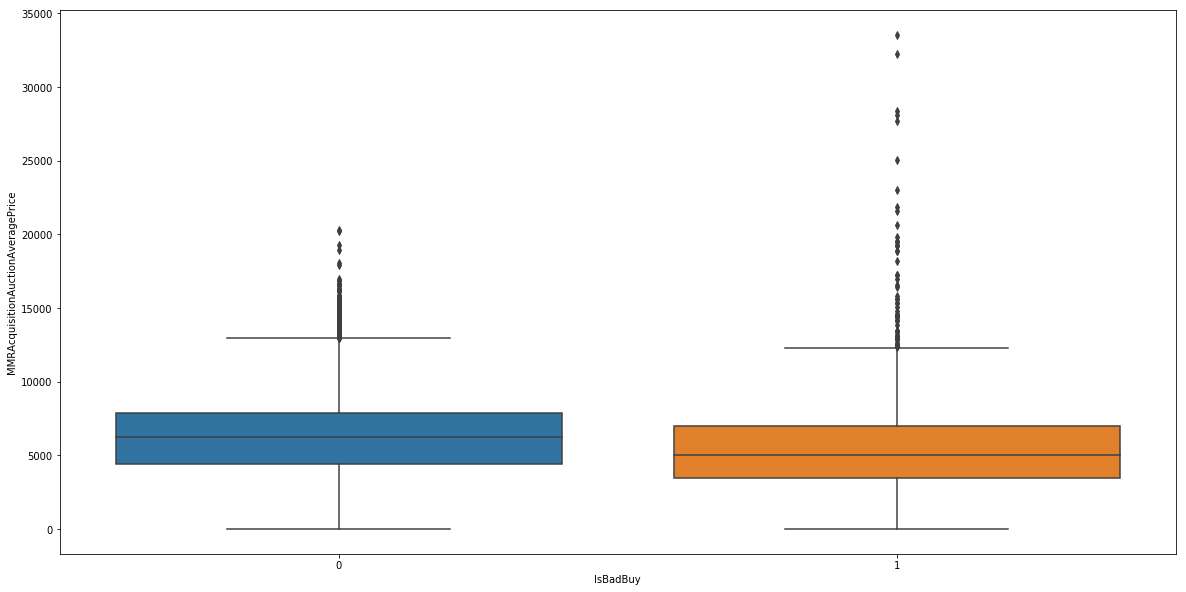

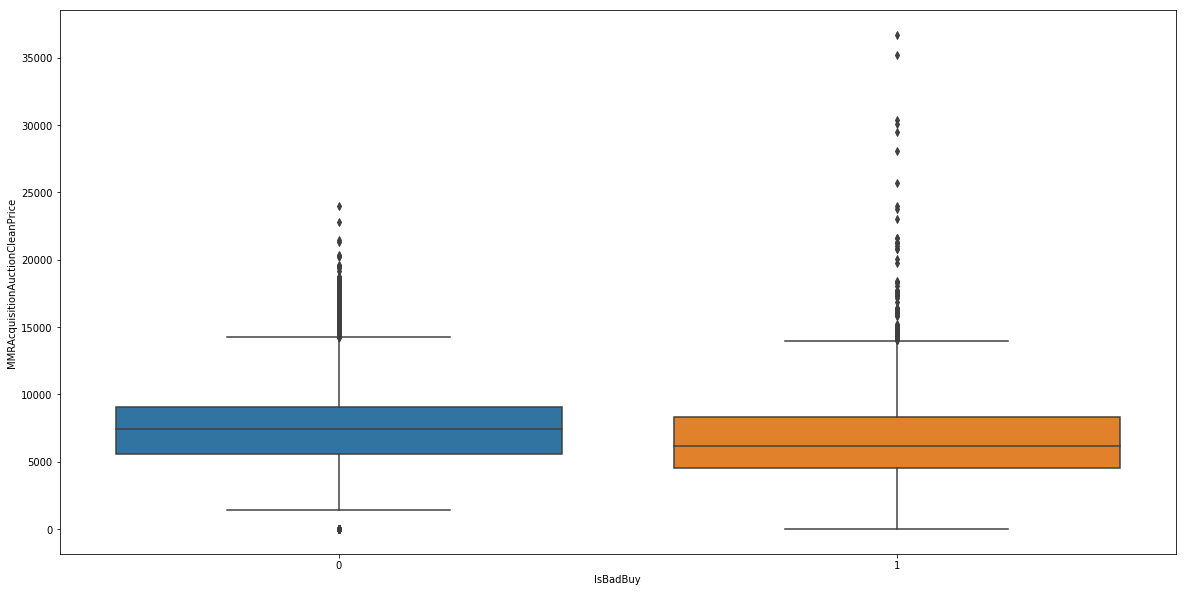

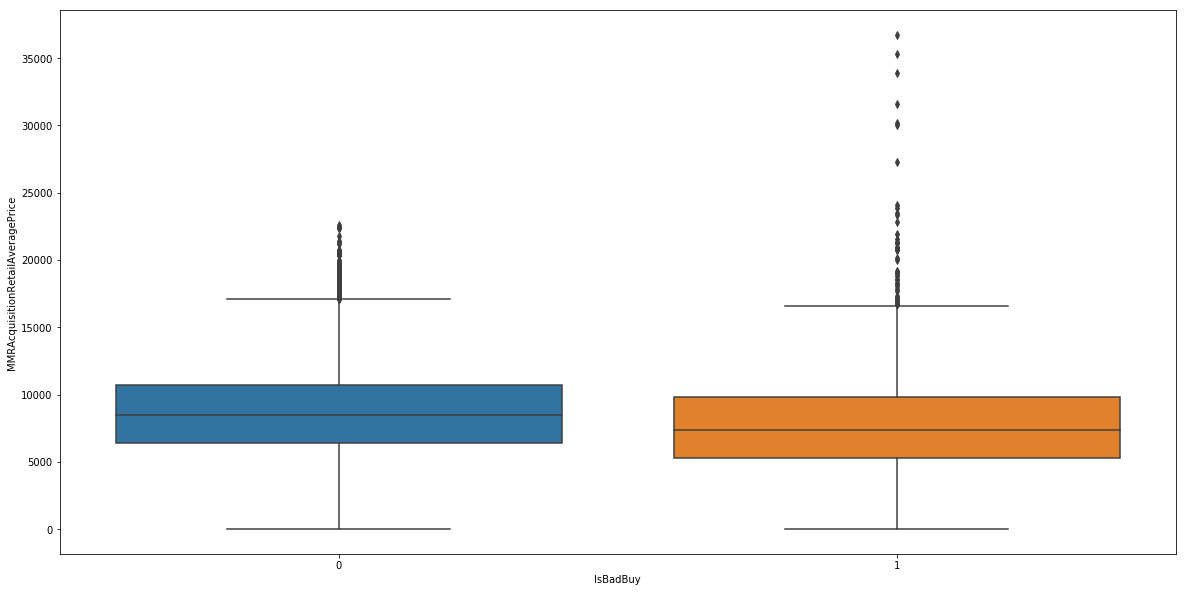

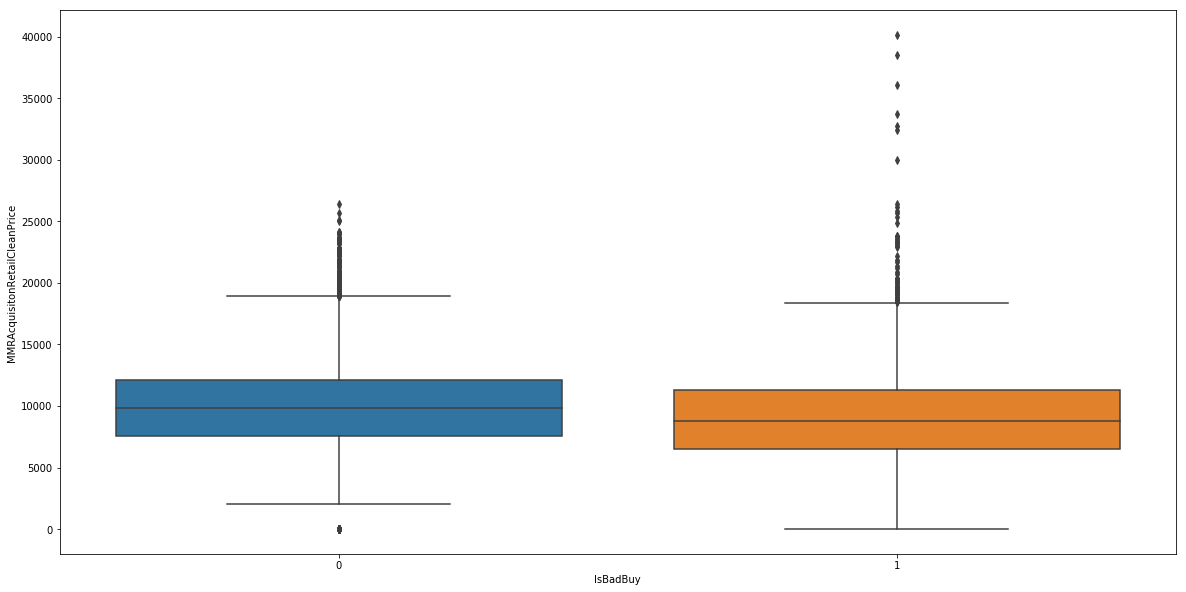

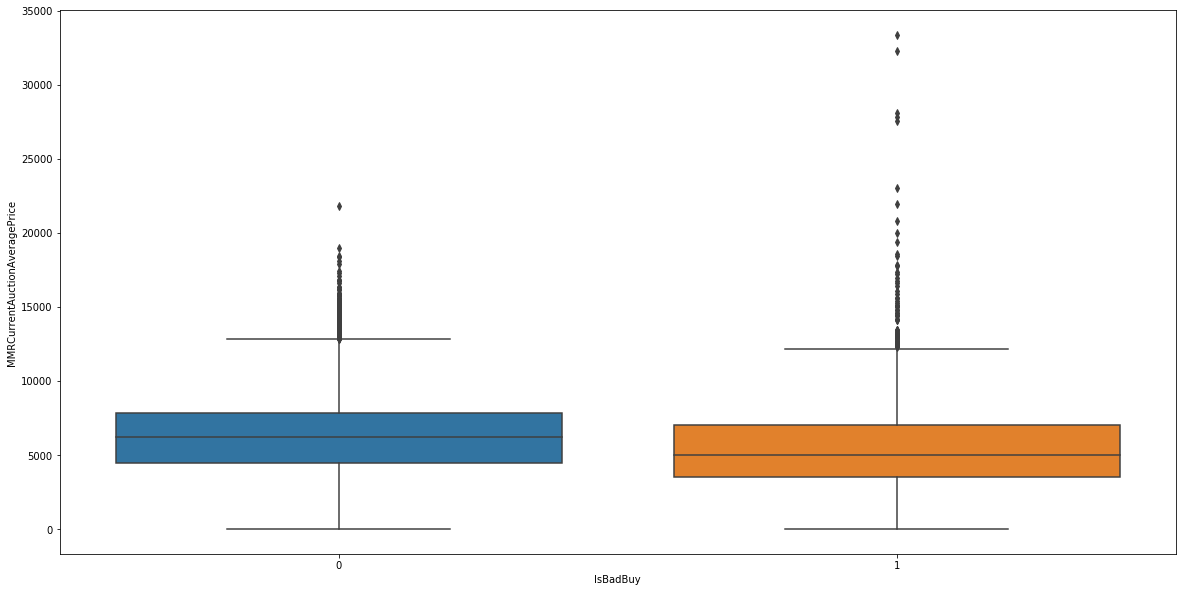

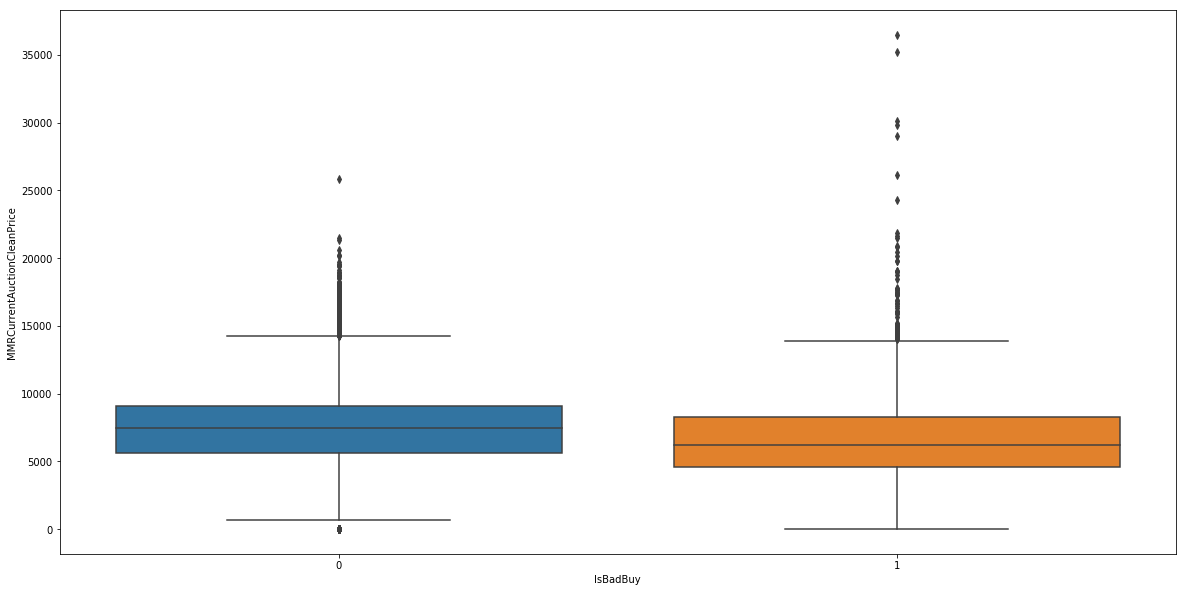

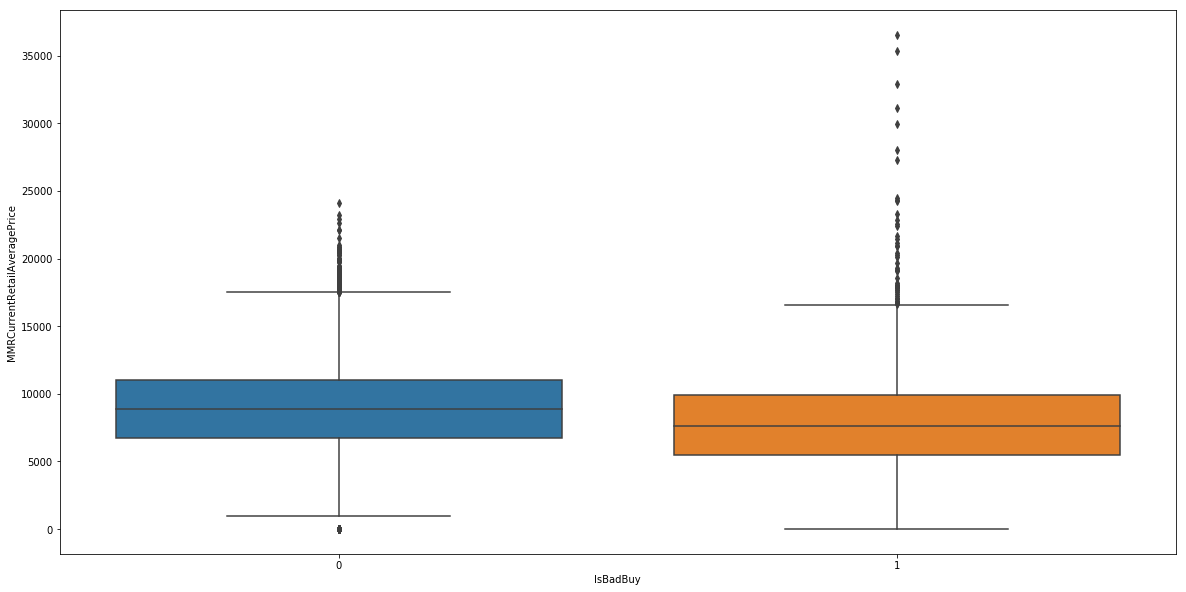

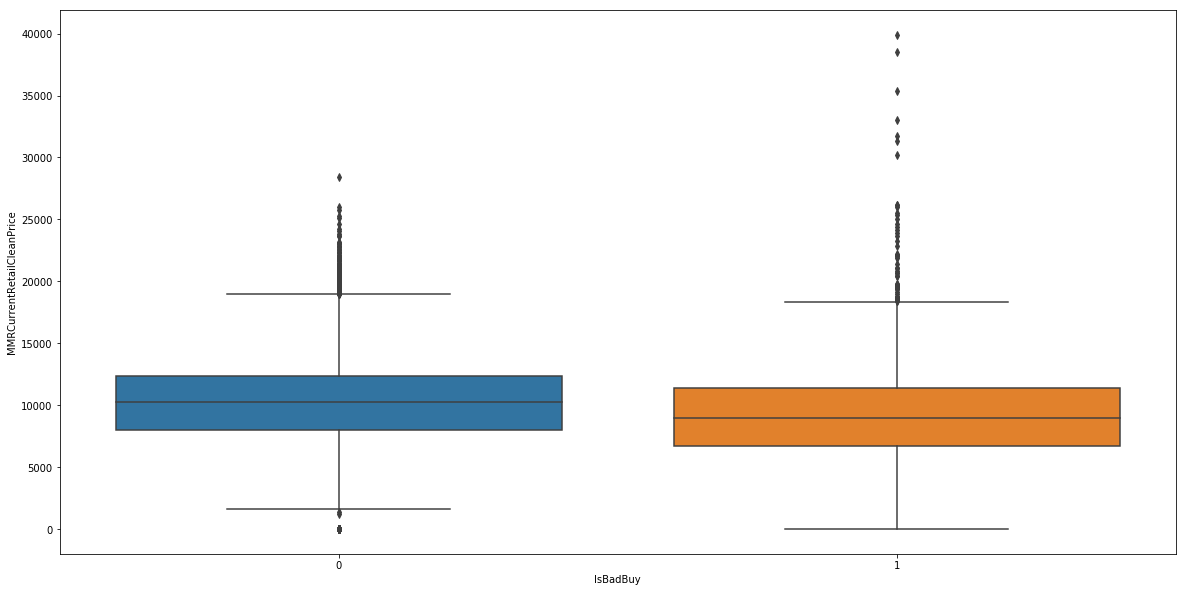

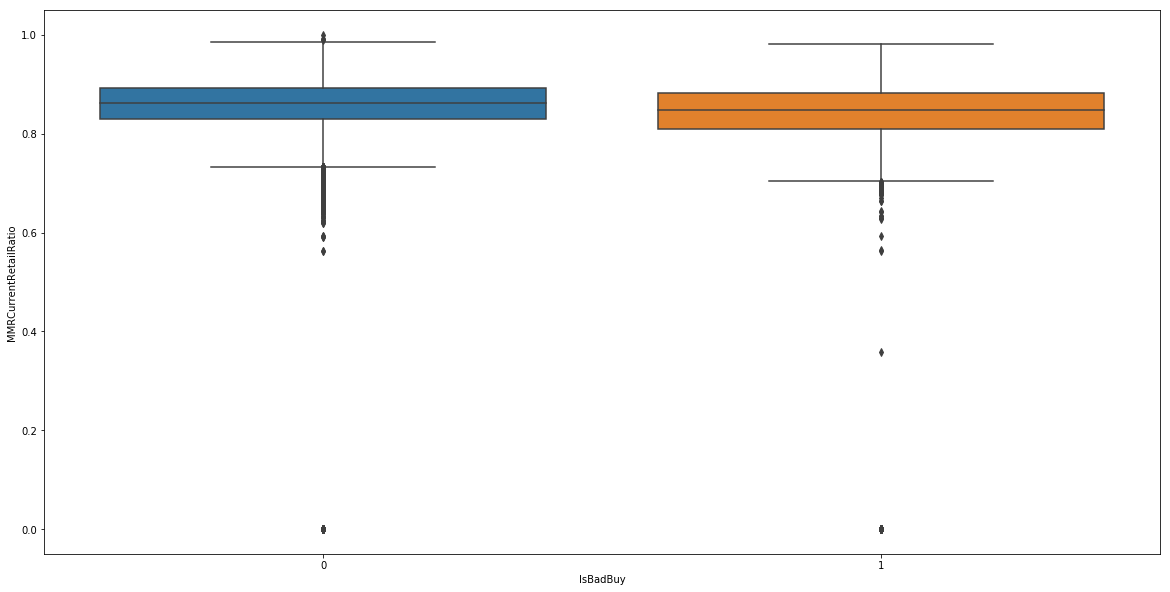

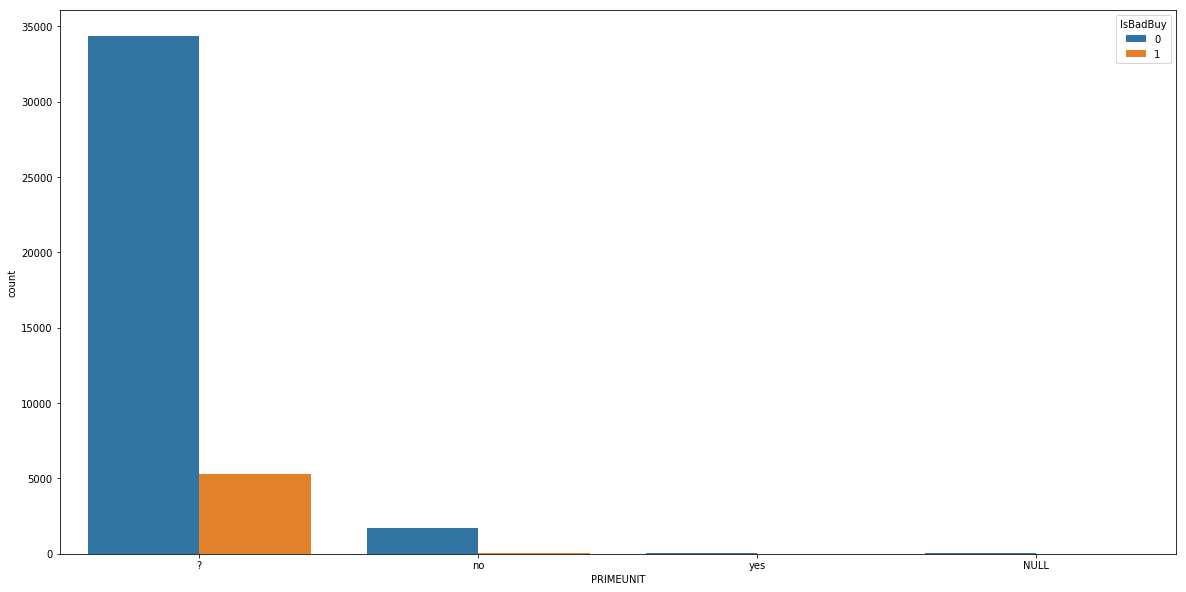

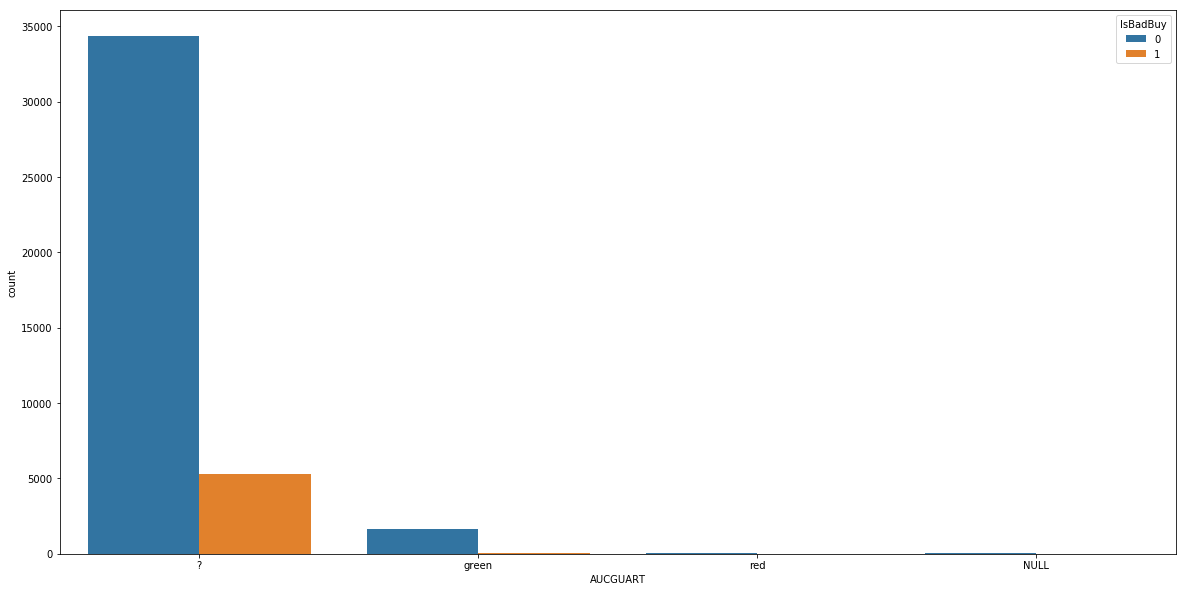

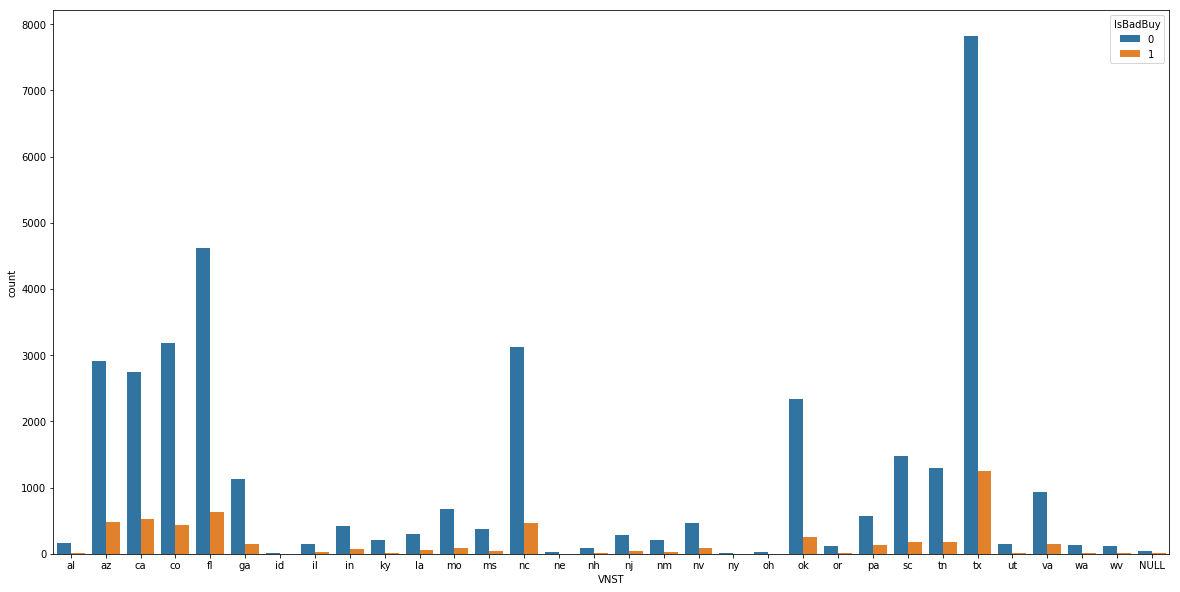

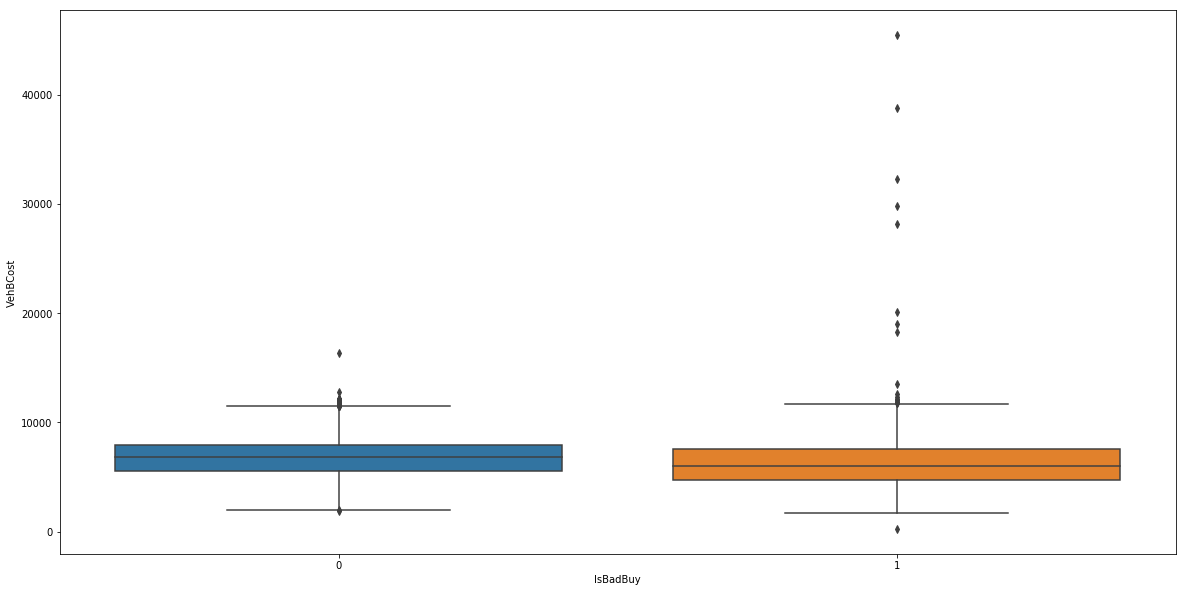

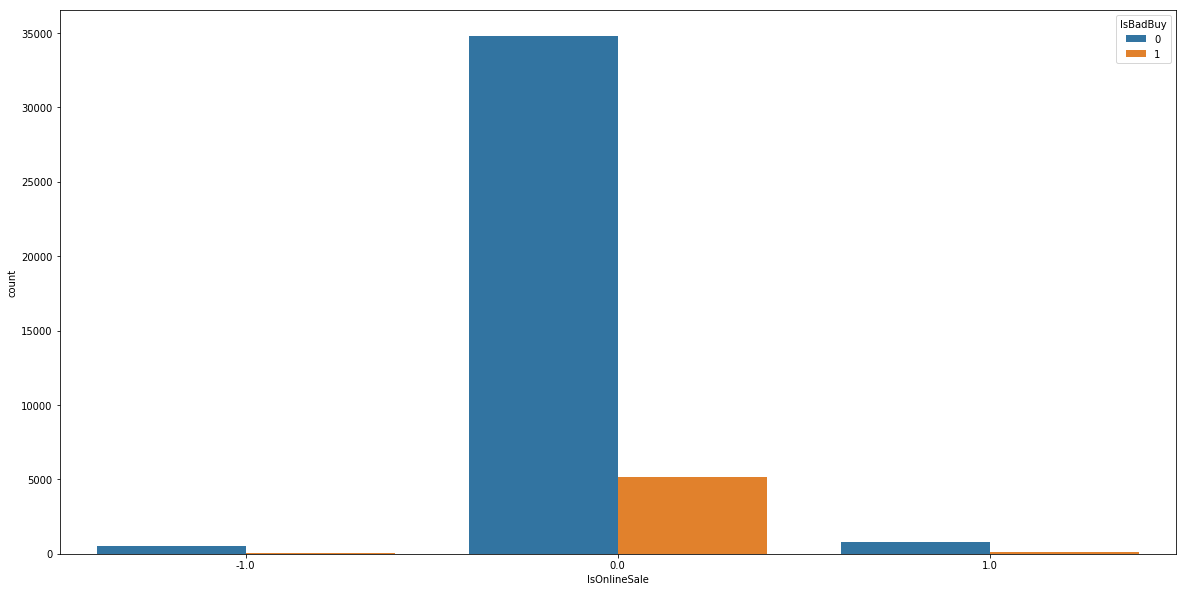

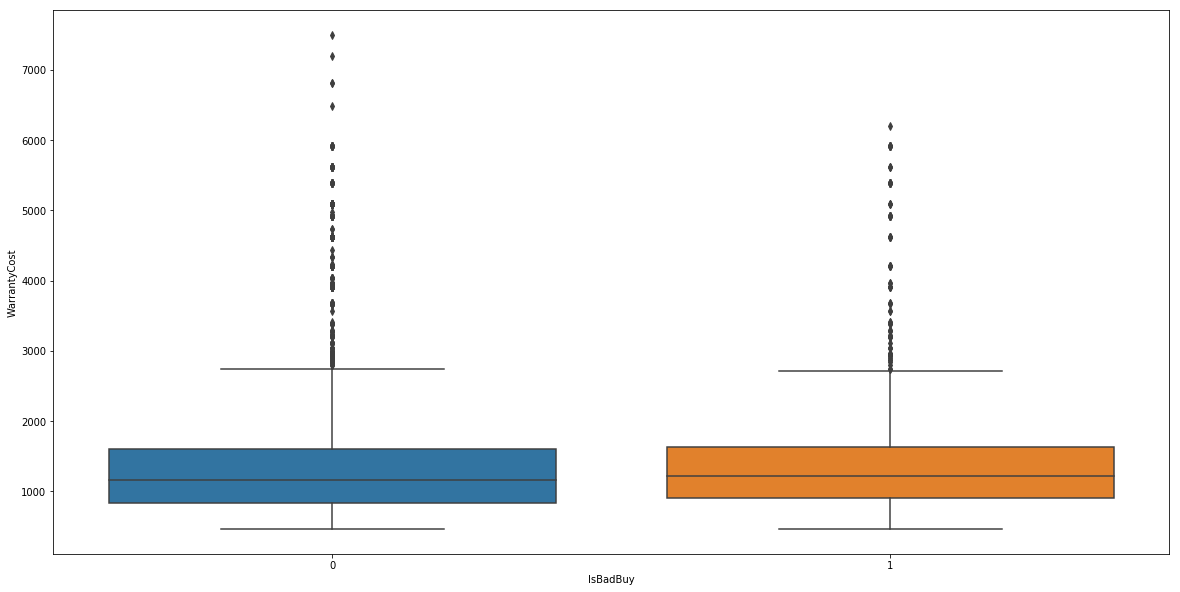

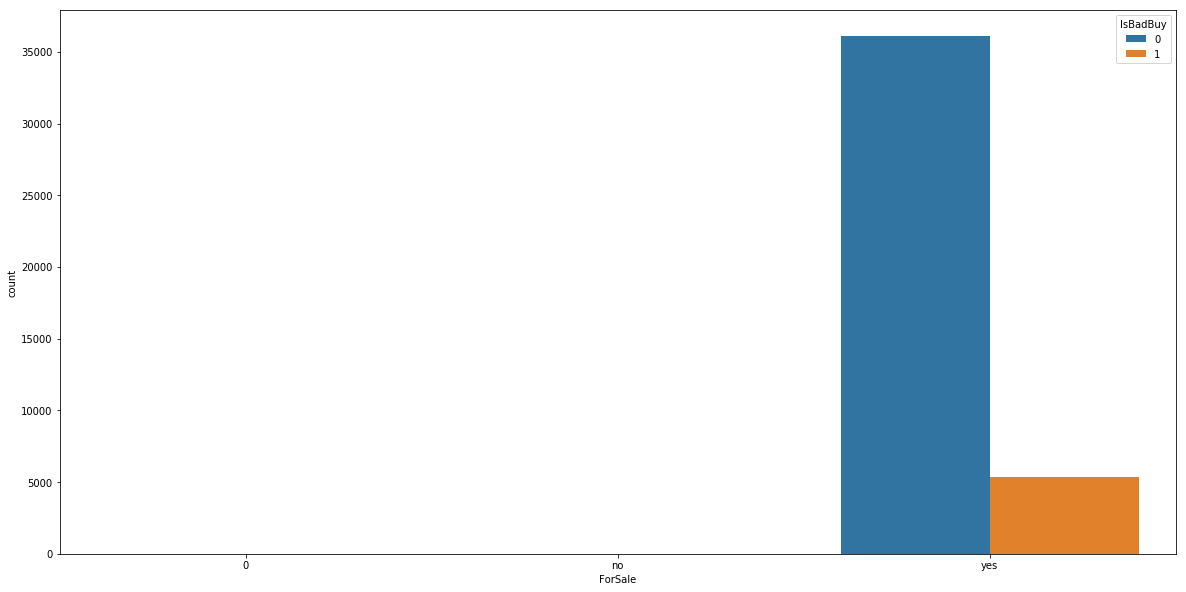

<Figure size 1440x720 with 0 Axes>

In [10]:
plotAllCols(df)

### 4. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice

### 5. What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection. 

In [11]:
# Change to the dummy 

df = pd.get_dummies(df)

feature_names = df.drop("IsBadBuy", axis=1).columns
print("Num of Features:", len(feature_names))

### Split to the training and test set. 
#  The test size is 3%

# y = df['IsBadBuy']
# X = df.drop(['IsBadBuy'], axis=1)
# X_mat = X.as_matrix()

# X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

X_train, X_test, y_train, y_test = train_test_split(df.drop("IsBadBuy", axis=1), df['IsBadBuy'], test_size=0.3, stratify=df['IsBadBuy'], random_state=rs)

if ResamplingMethod == 'ros':
    print("Using ROS Resmapling")
    ros = RandomOverSampler(random_state=rs)
    X_train, y_train = ros.fit_resample(X_train, y_train)
elif  ResamplingMethod == 'rus':
    print("Using RUS Resmapling")
    rus = RandomUnderSampler(random_state=rs)
    X_train, y_train = rus.fit_resample(X_train, y_train)
else:
    print("No Resampling Method Used")

Num of Features: 149
Using ROS Resmapling


In [12]:
print("Number of Training: ", len(X_train))
print("Number of Test: ", len(X_test) )

Number of Training:  50546
Number of Test:  12443


# Task 2. Predictive Modeling Using Decision Trees 

## 1. Python: Build a decision tree using the default setting. 

In [13]:
def printLRTopImportant(model, top = 5):
    
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file


In [14]:
# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best')

### a. What is the classification accuracy on training and test datasets?

In [15]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred) ## Confusion Matrix on the TestSet

Train accuracy: 0.9994856170616864
Test accuracy: 0.8286586835972033
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     10832
           1       0.35      0.37      0.36      1611

   micro avg       0.83      0.83      0.83     12443
   macro avg       0.63      0.63      0.63     12443
weighted avg       0.83      0.83      0.83     12443



array([[9714, 1118],
       [1014,  597]])

### b. What is the size of tree (i.e. number of nodes)?

In [16]:
print("Number of nodes: ", model.tree_.node_count)

Number of nodes:  6703


### c. How many leaves are in the tree that is selected based on the validation dataset?

### d. Which variable is used for the first split? What are the competing splits for this first split? 

In [17]:
visualize_decision_tree(model, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct.png")

### e. What are the 5 important variables in building the tree? 

In [18]:
analyse_feature_importance(model, df.drop("IsBadBuy", axis=1).columns, 5)

WheelTypeID_? : 0.13551426074337208
MMRCurrentAuctionAveragePrice : 0.07916633374386034
VehOdo : 0.06681157785792576
VehBCost : 0.06493159964208899
MMRCurrentRetailRatio : 0.06347311733157501


### f. Report if you see any evidence of model overfitting. 

### g. Did changing the default setting (i.e., only focus on changing the setting of the number of splits to create a node) help improving the model? Answer the above questions on the best performing tree.

## 2. Python: Build another decision tree tuned with GridSearchCV

In [19]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': list(range(2,7)) +[200, 500] + list(range(1, 6000, 1000)) + [None],
          'splitter': ['best', 'random'],
          'min_samples_leaf': range(1,  4),
          'min_samples_split': [2, 0.5, 0.3],
          'max_features':['auto','sqrt','log2', None],
          'class_weight':['balanced', None]
         }

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=101,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 200, 500, 1, 1001, 2001, 3001, 4001, 5001, None], 'splitter': ['best', 'random'], 'min_samples_leaf': range(1, 4), 'min_samples_split': [2, 0.5, 0.3], 'max_features': ['auto', 'sqrt', 'log2', None], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. What is the classification accuracy on training and test datasets?

In [20]:
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

# test the best model
y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)

dt_model = cv.best_estimator_

Train accuracy: 0.9994856170616864
Test accuracy: 0.8236759623884915
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10832
           1       0.32      0.32      0.32      1611

   micro avg       0.82      0.82      0.82     12443
   macro avg       0.61      0.61      0.61     12443
weighted avg       0.82      0.82      0.82     12443

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 200, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


### b. What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?

In [21]:
print("Number of nodes: ", cv.best_estimator_.tree_.node_count)

Number of nodes:  13743


### c. How many leaves are in the tree that is selected based on the validation dataset?

### d. Which variable is used for the first split? What are the competing splits for this first split? 

In [22]:
visualize_decision_tree(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, "Tree_Struct_CV.png")

### e. What are the 5 important variables in building the tree? 

In [23]:
analyse_feature_importance(cv.best_estimator_, df.drop("IsBadBuy", axis=1).columns, 5)

WheelType_? : 0.10196726739090486
VehBCost : 0.07747480575066952
VehOdo : 0.04975026240861232
MMRAcquisitionAuctionCleanPrice : 0.04953950838542224
MMRCurrentAuctionAveragePrice : 0.04898870588447332


### f. Report if you see any evidence of model overfitting. 

### g. What are the parameters used? Explain your choices.

## 3. What is the significant difference do you see between these two decision tree models (steps 2.1 & 2.2)? How do they compare performance-wise? Explain why those changes may have happened. 

## 4. From the better model, can you identify which cars could potential be “kicks”? Can you provide some descriptive summary of those cars?

# Task 3. Predictive Modeling Using Regression

## 1. In preparation for regression, is any imputation of missing values needed for this data set? List the variables that needed this.

In [24]:
# We've already done this in the prep_data function

## 2. Apply transformation method(s) to the variable(s) that need it. List the variables that needed it

In [25]:
## Doing the log transformation


### Q: It's enoguh?
columns_to_transform = interval_cols

def logTransformation(df):
    
    df_log = df.copy()

    
    for col in columns_to_transform:
        df_log[col] = df_log[col].apply(lambda x: x+1)
        df_log[col] = df_log[col].apply(np.log)
        
        
    return df_log

df_log = logTransformation(df)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(df_log.drop(['IsBadBuy'], axis=1), df_log['IsBadBuy'], test_size=0.3, stratify=df_log['IsBadBuy']
,random_state=rs)


if ResamplingMethod == 'ros':
    print("Using ROS Resmapling")
    ros = RandomOverSampler(random_state=rs)
    X_train_log, y_train_log = ros.fit_resample(X_train_log, y_train_log)
elif  ResamplingMethod == 'rus':
    print("Using RUS Resmapling")
    rus = RandomUnderSampler(random_state=rs)
    X_train_log, y_train_log = rus.fit_resample(X_train_log, y_train_log)
else:
    print("No Resampling Method Used")



# Standardise
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)


Using ROS Resmapling


## 3. Build a regression model using the default regression method with all inputs. Once you done it, build another one and tune it using GridSearchCV. Answer the followings:

In [26]:
### Traing Logistic Regression
model = LogisticRegression(random_state=rs)
model.fit(X_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
## GridSearch for Logistic Regression
params = {
    'C': [pow(10, x) for x in range(-4, 1)],
    'solver' : ['newton-cg',"lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [30, 50, 100],
    'warm_start': [True, False],
    'class_weight':['balanced', None]
}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=3, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [30, 50, 100], 'warm_start': [True, False], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### h. Name the regression function used.

### i. How much was the difference in performance of two models build, default and optimal?

In [28]:
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))

Train accuracy: 0.6998773394531713
Test accuracy: 0.7560877601864502
GridSearch Train accuracy: 0.7009456732481304
GridSearch Test accuracy: 0.7552840954753677


### j. Show the set parameters for the best model. What are the parameters used? Explain your decision. What are the optimal parameters?

In [29]:
print("The best model parameters: ", cv.best_params_)

The best model parameters:  {'C': 1, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'lbfgs', 'warm_start': True}


### k. Report which variables are included in the regression model.

### l. Report the top-5 important variables (in the order) in the model.

In [30]:
def printLRTopImportant(model, top = 5):
    
    coef = model.coef_[0]
    indices = np.argsort(np.absolute(coef))
    indices = np.flip(indices, axis=0)
    indices = indices[:top]
    for i in indices:
        print(feature_names[i], ':', coef[i])

In [31]:
printLRTopImportant(model, 5)

MMRAcquisitionAuctionAveragePrice : -1.8301352716819697
MMRAcquisitionRetailAveragePrice : 1.556335135697774
MMRCurrentRetailCleanPrice : -1.1608985500248494
WheelTypeID_? : 0.7647388496623555
MMRCurrentAuctionAveragePrice : 0.7090035140103588


### m. What is classification accuracy on training and test datasets?

In [32]:
y_pred = model.predict(X_test_log)
print("Classification Report: \n\n",classification_report(y_test_log, y_pred))

y_pred = cv.predict(X_test_log)
print("GridSearch Classification Report: \n\n",classification_report(y_test_log, y_pred))
log_reg_model = cv.best_estimator_

Classification Report: 

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.61      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.85      0.76      0.79     12443

GridSearch Classification Report: 

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.61      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.85      0.76      0.79     12443



### n. Report any sign of overfitting.

In [33]:
## The GridSearch Precision and Recall is weird

## 4. Build another regression model using the subset of inputs selected by RFE and selection by model method. Answer the followings:

In [34]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=3)
rfe.fit(X_train_log, y_train_log)
X_train_rfe = rfe.transform(X_train_log)
X_test_rfe = rfe.transform(X_test_log)

selectmodel = SelectFromModel(dt_model, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

### a. Report which variables are included in the regression model.

In [35]:
print("Original feature set", X_train.shape[1])
print("Number of RFE-selected features: ", rfe.n_features_)
print("Number of selectFromModel features: ",  X_train_sel_model.shape[1])

Original feature set 149
Number of RFE-selected features:  126
Number of selectFromModel features:  24


In [36]:
print("The RFE-selected features: \n\n", list(compress(feature_names, rfe.support_)))
print("\n\n")
print("The SelectFromModel features: \n\n",list(compress(feature_names, selectmodel.get_support())))

The RFE-selected features: 

 ['VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'MMRCurrentRetailRatio', 'VehBCost', 'WarrantyCost', 'Auction_adesa', 'Auction_manheim', 'Auction_other', 'VehYear_2001.0', 'VehYear_2002.0', 'VehYear_2003.0', 'VehYear_2004.0', 'VehYear_2005.0', 'VehYear_2006.0', 'VehYear_2007.0', 'VehYear_2008.0', 'VehYear_2009.0', 'VehYear_2010.0', 'VehYear_UNKNOWN_VALUE', 'Make_acura', 'Make_buick', 'Make_chevrolet', 'Make_chrysler', 'Make_dodge', 'Make_ford', 'Make_honda', 'Make_infiniti', 'Make_isuzu', 'Make_jeep', 'Make_kia', 'Make_lexus', 'Make_lincoln', 'Make_mini', 'Make_mitsubishi', 'Make_nissan', 'Make_oldsmobile', 'Make_pontiac', 'Make_saturn', 'Make_scion', 'Make_subaru', 'Make_suzuki', 'Make_toyota', 'Make_volvo', 'Color_beige', 'Color

### b. Report the top-5 important variables (in the order) in the model.

In [37]:
params = {
    'C': [pow(10, x) for x in range(-4, 1)],
    'solver' : ['newton-cg',"lbfgs", "liblinear", "sag", "saga"],
    'max_iter': [30, 50, 100],
    'warm_start': [True, False],
    'class_weight':['balanced', None]

}
rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs, verbose=True), cv=3, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_log)

selectModel_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs, verbose=True), cv=3, n_jobs=-1)
selectModel_cv.fit(X_train_sel_model, y_train_log)


[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=101, solver='warn',
          tol=0.0001, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [30, 50, 100], 'warm_start': [True, False], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
print("Top-5 important variables for RFE: \n")
printLRTopImportant(rfe_cv.best_estimator_, 5)
print("\n\n")
print("Top-5 important variables for selectModel \n")
printLRTopImportant(selectModel_cv.best_estimator_, 5)

Top-5 important variables for RFE: 

MMRAcquisitionAuctionAveragePrice : -1.2007986138089202
MMRAcquisitionRetailAveragePrice : 1.1707944988856998
MMRCurrentRetailCleanPrice : -0.5862338769571586
Color_white : 0.5771408731924557
MMRAcquisitonRetailCleanPrice : 0.5560971039889662



Top-5 important variables for selectModel 

MMRCurrentRetailAveragePrice : -3.155872487409825
MMRCurrentRetailCleanPrice : 2.2997683935748934
MMRAcquisitionAuctionAveragePrice : -1.8616373108354378
VehYear_2005.0 : 1.2396144583206734
MMRAcquisitonRetailCleanPrice : 0.9311113016898371


### c. What are the parameters used? Explain your choices. What are the optimal parameters? Which regression function is being used?

In [39]:
print("Optimal Parameters for RFE", rfe_cv.best_params_)
print("Optimal Parameters for selectModel", selectModel_cv.best_params_)

Optimal Parameters for RFE {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'liblinear', 'warm_start': True}
Optimal Parameters for selectModel {'C': 1, 'class_weight': 'balanced', 'max_iter': 30, 'solver': 'newton-cg', 'warm_start': True}


### d. Report any sign of overfitting

### e. What is classification accuracy on training and test datasets?

In [40]:
print("GridSearch Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch Test accuracy:", cv.score(X_test_log, y_test_log))
print("\n\nRFE:\n")
print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train_log))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test_log))
print("\n\nselectModel:\n")
print("Train accuracy:", selectModel_cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", selectModel_cv.score(X_test_sel_model, y_test_log))

GridSearch Train accuracy: 0.7009456732481304
GridSearch Test accuracy: 0.7552840954753677


RFE:

Train accuracy: 0.7000949630039963
Test accuracy: 0.7568914248975327


selectModel:

Train accuracy: 0.6835951410596288
Test accuracy: 0.7648477055372499


### f. Did it improve/worsen the performance? Explain why those changes may have happened

In [41]:
y_pred = rfe_cv.predict(X_test_rfe)
print("REF classification report: \n",classification_report(y_test, y_pred))
print("\n\n")
y_pred = selectModel_cv.predict(X_test_sel_model)
print("selectModel classification report: \n",classification_report(y_test, y_pred))

REF classification report: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.60      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.85      0.76      0.79     12443




selectModel classification report: 
               precision    recall  f1-score   support

           0       0.92      0.79      0.85     10832
           1       0.29      0.57      0.38      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.68      0.62     12443
weighted avg       0.84      0.76      0.79     12443



 # Task4 - Predicting using neural network

## 1. Build a Neural Network model using the default setting. Answer the following:

In [42]:
model = MLPClassifier(random_state=rs)
model.fit(X_train_log, y_train_log)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### a. What is the network architecture?

In [43]:
def printMLPArchitecture(model):

    print("Number of Layers: ",model.n_layers_ )
    print("The First layer is Input Layer, and the last layer is the output layer")
    for i, w in enumerate(model.coefs_):
        print("{} Layer with hidden size {}".format(i+1, w.shape[0]))
        if (i+1) == len(model.coefs_):
            print("{} Layer with hidden size {}".format(i+2, w.shape[1]))
    
    print("The activation function: ", model.activation)
            
printMLPArchitecture(model)

Number of Layers:  3
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 149
2 Layer with hidden size 100
3 Layer with hidden size 1
The activation function:  relu


### b. How many iterations are needed to train this network?

In [44]:
print("Number of iterations it ran: ", model.n_iter_)

Number of iterations it ran:  200


### c. Do you see any sign of over-fitting?

In [45]:
# fig = plt.figure(figsize=(10, 5))
# plt.ylabel('Accuracy',fontsize=15)
# plt.xlabel('Number of iterations',fontsize=15)
# plt.title('Validation Accuracy',fontsize=20,fontweight ="bold")
# plt.plot(model.validation_scores_, label="Validation Accuracy")

### d. Did the training process converge and resulted in the best model? 

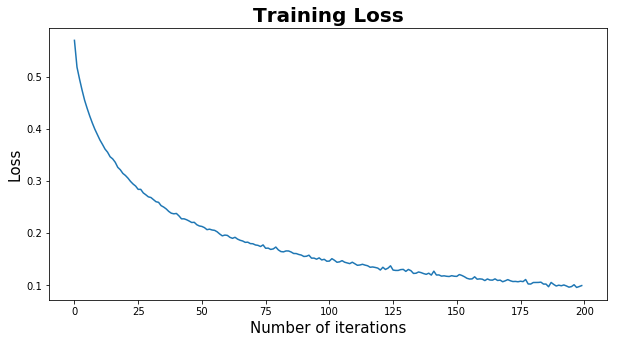

In [46]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(model.loss_curve_, label="Training Loss")

### The Loss curve is still decreasing

### e. What is classification accuracy on training and test datasets?

In [47]:
print("MLP Train accuracy:", model.score(X_train, y_train))
print("MLP Test accuracy:", model.score(X_test, y_test))
print("\n\n")
y_pred = model.predict(X_test)
print("MLP classification report: \n",classification_report(y_test, y_pred))

MLP Train accuracy: 0.459660507260713
MLP Test accuracy: 0.6925982480109298



MLP classification report: 
               precision    recall  f1-score   support

           0       0.86      0.77      0.81     10832
           1       0.09      0.14      0.11      1611

   micro avg       0.69      0.69      0.69     12443
   macro avg       0.47      0.46      0.46     12443
weighted avg       0.76      0.69      0.72     12443



## 2. Refine this network by tuning it with GridSearchCV. 

In [48]:
# Default
# params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

params = [
    {
        'hidden_layer_sizes': [(128, 64, 32, 16)],
        'activation': ['relu'],
        'solver' : ['adam',],
        'batch_size': [64],
        'shuffle': [True],
        'learning_rate_init': [0.001],
        'n_iter_no_change': [10],
        'max_iter':[200],
        'warm_start': [True],
        'early_stopping': [True],
        'alpha': [0.01, 0.001],
    },      
]


cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, verbose=True), cv=3, n_jobs=-1)
# cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, max_iter = max_iter, n_iter_no_change = max_iter ), cv=3, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

Iteration 1, loss = 0.54693080
Validation score: 0.735312
Iteration 2, loss = 0.47179153
Validation score: 0.777844
Iteration 3, loss = 0.40331981
Validation score: 0.812265
Iteration 4, loss = 0.33787091
Validation score: 0.831454
Iteration 5, loss = 0.29212924
Validation score: 0.867656
Iteration 6, loss = 0.25190921
Validation score: 0.881701
Iteration 7, loss = 0.21855853
Validation score: 0.883680
Iteration 8, loss = 0.19788286
Validation score: 0.902868
Iteration 9, loss = 0.18081237
Validation score: 0.910584
Iteration 10, loss = 0.16247232
Validation score: 0.901879
Iteration 11, loss = 0.15504546
Validation score: 0.905440
Iteration 12, loss = 0.14536334
Validation score: 0.916716
Iteration 13, loss = 0.13576600
Validation score: 0.918101
Iteration 14, loss = 0.13033542
Validation score: 0.916716
Iteration 15, loss = 0.12545532
Validation score: 0.918101
Iteration 16, loss = 0.11629657
Validation score: 0.904055
Iteration 17, loss = 0.11284304
Validation score: 0.921464
Iterat

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [(128, 64, 32, 16)], 'activation': ['relu'], 'solver': ['adam'], 'batch_size': [64], 'shuffle': [True], 'learning_rate_init': [0.001], 'n_iter_no_change': [10], 'max_iter': [200], 'warm_start': [True], 'early_stopping': [True], 'alpha': [0.01, 0.001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### a. What is the network architecture?

In [49]:
print("Best Parameters of NN: ", cv.best_params_)

Best Parameters of NN:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}


In [50]:
printMLPArchitecture(cv.best_estimator_)

Number of Layers:  6
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 149
2 Layer with hidden size 128
3 Layer with hidden size 64
4 Layer with hidden size 32
5 Layer with hidden size 16
6 Layer with hidden size 1
The activation function:  relu


# b. How many iterations are needed to train this network?

In [51]:
print("Number of iterations it ran: ",cv.best_estimator_.n_iter_)

Number of iterations it ran:  83


### c. Sign of overfitting?

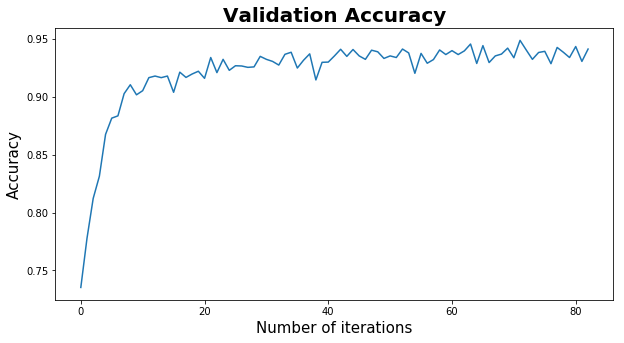

In [52]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Validation Accuracy',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.validation_scores_, label="Validation Accuracy")

### d. Did the training process converge and resulted in the best model? 

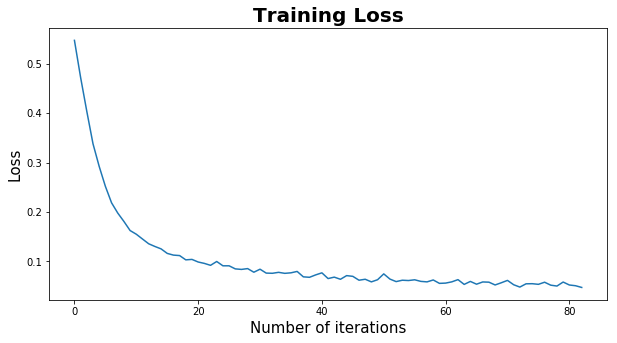

In [53]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.loss_curve_, label="Training Loss")


### e. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [54]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))

print("\n\n")
y_pred = cv.predict(X_test_log)
print("GridSearch NN Classification Report: \n",classification_report(y_test_log, y_pred))

print("Best Parameters of NN: ", cv.best_params_)
nn_model = cv.best_estimator_

GridSearch NN Train accuracy: 0.9844893760139279
GridSearch NN Test accuracy: 0.8415976854456321



GridSearch NN Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     10832
           1       0.37      0.33      0.35      1611

   micro avg       0.84      0.84      0.84     12443
   macro avg       0.64      0.63      0.63     12443
weighted avg       0.83      0.84      0.84     12443

Best Parameters of NN:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}


## 3. Would feature selection help here? Build another Neural Network model with inputs selected from RFE with regression (use the best model generated in Task 3) and selection with decision tree (use the best model from Task 2).

In [55]:
params = [
    {
        'hidden_layer_sizes': [(128, 64, 32, 16)],
        'activation': ['relu'],
        'solver' : ['adam',],
        'batch_size': [64],
        'shuffle': [True],
        'learning_rate_init': [0.001],
        'n_iter_no_change': [10],
        'max_iter':[200],
        'warm_start': [True],
        'early_stopping': [True],
        'alpha': [0.01, 0.001],
    },      
]



rfe_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, verbose=True), cv=3, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train_log)
modelSelect_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True, verbose=True), cv=3, n_jobs=-1)
modelSelect_cv.fit(X_train_sel_model, y_train_log)

Iteration 1, loss = 0.54379255
Validation score: 0.727003
Iteration 2, loss = 0.47608808
Validation score: 0.768150
Iteration 3, loss = 0.42003955
Validation score: 0.799209
Iteration 4, loss = 0.36825116
Validation score: 0.798813
Iteration 5, loss = 0.31963542
Validation score: 0.834224
Iteration 6, loss = 0.27991410
Validation score: 0.857369
Iteration 7, loss = 0.25017291
Validation score: 0.868843
Iteration 8, loss = 0.22515935
Validation score: 0.874777
Iteration 9, loss = 0.20524337
Validation score: 0.881108
Iteration 10, loss = 0.18742855
Validation score: 0.893175
Iteration 11, loss = 0.17456972
Validation score: 0.890999
Iteration 12, loss = 0.16126007
Validation score: 0.902077
Iteration 13, loss = 0.15218531
Validation score: 0.901682
Iteration 14, loss = 0.14374594
Validation score: 0.900495
Iteration 15, loss = 0.13717406
Validation score: 0.908012
Iteration 16, loss = 0.12471034
Validation score: 0.901879
Iteration 17, loss = 0.12454071
Validation score: 0.910188
Iterat

Iteration 97, loss = 0.12256008
Validation score: 0.905242
Iteration 98, loss = 0.11431645
Validation score: 0.912760
Iteration 99, loss = 0.11201425
Validation score: 0.915529
Iteration 100, loss = 0.10848371
Validation score: 0.909397
Iteration 101, loss = 0.10614389
Validation score: 0.904649
Iteration 102, loss = 0.11164762
Validation score: 0.916914
Iteration 103, loss = 0.11209671
Validation score: 0.905836
Iteration 104, loss = 0.10906200
Validation score: 0.910188
Iteration 105, loss = 0.10476748
Validation score: 0.909990
Iteration 106, loss = 0.11122429
Validation score: 0.909792
Iteration 107, loss = 0.10502549
Validation score: 0.919288
Iteration 108, loss = 0.10180094
Validation score: 0.918892
Iteration 109, loss = 0.10136023
Validation score: 0.908012
Iteration 110, loss = 0.10664119
Validation score: 0.917507
Iteration 111, loss = 0.10293620
Validation score: 0.916320
Iteration 112, loss = 0.11947076
Validation score: 0.894164
Iteration 113, loss = 0.11190286
Validation

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=101, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'hidden_layer_sizes': [(128,), (128, 64, 32)], 'activation': ['logistic', 'relu'], 'solver': ['adam'], 'batch_size': [64], 'shuffle': [True], 'learning_rate_init': [0.001], 'n_iter_no_change': [10], 'max_iter': [200], 'warm_start': [True], 'early_stopping': [True], 'alpha': [0.1, 0.0001...er_no_change': [10], 'warm_start': [True], 'early_stopping': [True], 'alpha': [0.1, 0.0001, 1e-06]}],
       pre_dispatch

### a. Did feature selection help here? Any change in the network architecture? What inputs are being used as the network input?

In [56]:
print("Best Parameters of NN: ", cv.best_params_)
print("Best Parameters of RFE NN: ", rfe_cv.best_params_)
print("Best Parameters of modelSelect NN: ", modelSelect_cv.best_params_)
print("\n\n")

print("GridSearch:")
printMLPArchitecture(cv.best_estimator_)
print("\n")
print("RFE:")
printMLPArchitecture(rfe_cv.best_estimator_)
print("\n")
print("modelSelect:")
printMLPArchitecture(modelSelect_cv.best_estimator_)
print("\n")


Best Parameters of NN:  {'activation': 'relu', 'alpha': 0.001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}
Best Parameters of RFE NN:  {'activation': 'relu', 'alpha': 1e-06, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}
Best Parameters of modelSelect NN:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'shuffle': True, 'solver': 'adam', 'warm_start': True}



GridSearch:
Number of Layers:  6
The First layer is Input Layer, and the last layer is the output layer
1 Layer with hidden size 149
2 Layer with hidden size 128
3 Layer with 

### b. What is classification accuracy on training and test datasets? Is there any improvement in the outcome?

In [57]:
print("GridSearch NN Train accuracy:", cv.score(X_train_log, y_train_log))
print("GridSearch NN Test accuracy:", cv.score(X_test_log, y_test_log))
print("RFE NN Train accuracy:", rfe_cv.score(X_train_rfe, y_train_log))
print("RFE NNTest accuracy:", rfe_cv.score(X_test_rfe, y_test_log))
print("modelSelect NN Train accuracy:", modelSelect_cv.score(X_train_sel_model, y_train_log))
print("modelSelect NN Test accuracmodelSelect_cvy:", modelSelect_cv.score(X_test_sel_model, y_test_log))

GridSearch NN Train accuracy: 0.9844893760139279
GridSearch NN Test accuracy: 0.8415976854456321
RFE NN Train accuracy: 0.9759624896134215
RFE NNTest accuracy: 0.8274531865305794
modelSelect NN Train accuracy: 0.9666640288054446
modelSelect NN Test accuracmodelSelect_cvy: 0.8104958611267379


### c. How many iterations are now needed to train this network?

In [58]:
print("Number of iterations GS ran: ",cv.best_estimator_.n_iter_)
print("Number of iterations rfe ran: ",rfe_cv.best_estimator_.n_iter_)
print("Number of iterations modelSelect ran: ",modelSelect_cv.best_estimator_.n_iter_)

Number of iterations GS ran:  83
Number of iterations rfe ran:  42
Number of iterations modelSelect ran:  132


### d. Do you see any sign of over-fitting?

### e. Did the training process converge and resulted in the best model? 

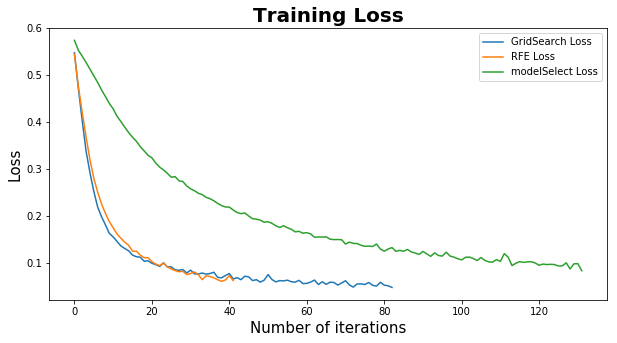

In [59]:
fig = plt.figure(figsize=(10, 5))
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Number of iterations',fontsize=15)
plt.title('Training Loss',fontsize=20,fontweight ="bold")
plt.plot(cv.best_estimator_.loss_curve_, label="GridSearch Loss")
plt.plot(rfe_cv.best_estimator_.loss_curve_, label="RFE Loss")
plt.plot(modelSelect_cv.best_estimator_.loss_curve_, label="modelSelect Loss")
plt.legend(loc='upper right')

# 4. Using the comparison methods, which of the models (i.e one with selected variables and another with all variables) appears to be better? From the better model, can you identify cars those could potential be “kicks”? Can you provide some descriptive summary of those cars? Is it easy to comprehend the performance of the best neural network model for decision making?

In [60]:
print("GridSearch Classification Report: ")
y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))
print("\n\nRFE Classification Report: ")
y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test_log, y_pred))
print("\n\nmodelSelect Classification Report: ")
y_pred = modelSelect_cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

GridSearch Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     10832
           1       0.37      0.33      0.35      1611

   micro avg       0.84      0.84      0.84     12443
   macro avg       0.64      0.63      0.63     12443
weighted avg       0.83      0.84      0.84     12443



RFE Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10832
           1       0.34      0.35      0.35      1611

   micro avg       0.83      0.83      0.83     12443
   macro avg       0.62      0.63      0.62     12443
weighted avg       0.83      0.83      0.83     12443



modelSelect Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     10832
           1       0.30      0.35      0.33      1611

   micro avg       0.81      0.81      0.81     12443
   macro avg       0.60  

# Task 5. Generating an Ensemble Model and Comparing Models

## 1. Generate an ensemble model to include the best regression model, best decision tree model, and best neural network model.

In [61]:
voting = VotingClassifier(estimators=[('dt', dt_model), ('lr', log_reg_model), ('nn', nn_model)], voting='soft')
voting.fit(X_train_log, y_train_log)

y_pred_dt = dt_model.predict(X_test_log)
y_pred_log_reg = log_reg_model.predict(X_test_log)
y_pred_nn = nn_model.predict(X_test_log)
y_pred_ensemble = voting.predict(X_test_log)


Iteration 1, loss = 0.54693080
Validation score: 0.735312
Iteration 2, loss = 0.47179153
Validation score: 0.777844
Iteration 3, loss = 0.40331981
Validation score: 0.812265
Iteration 4, loss = 0.33787091
Validation score: 0.831454
Iteration 5, loss = 0.29212924
Validation score: 0.867656
Iteration 6, loss = 0.25190921
Validation score: 0.881701
Iteration 7, loss = 0.21855853
Validation score: 0.883680
Iteration 8, loss = 0.19788286
Validation score: 0.902868
Iteration 9, loss = 0.18081237
Validation score: 0.910584
Iteration 10, loss = 0.16247232
Validation score: 0.901879
Iteration 11, loss = 0.15504546
Validation score: 0.905440
Iteration 12, loss = 0.14536334
Validation score: 0.916716
Iteration 13, loss = 0.13576600
Validation score: 0.918101
Iteration 14, loss = 0.13033542
Validation score: 0.916716
Iteration 15, loss = 0.12545532
Validation score: 0.918101
Iteration 16, loss = 0.11629657
Validation score: 0.904055
Iteration 17, loss = 0.11284304
Validation score: 0.921464
Iterat

### a. Does the Ensemble model outperform the underlying models? Resonate your answer.

In [62]:
print("Report for DT: \n",classification_report(y_test_log, y_pred_dt))
print("\nReport for Logistic Regression: \n",classification_report(y_test_log, y_pred_log_reg))
print("\nReport for NN: \n",classification_report(y_test_log, y_pred_nn))
print("\nReport for Ensemble: \n",classification_report(y_test_log, y_pred_ensemble))

Report for DT: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     10832
           1       0.16      0.07      0.10      1611

   micro avg       0.83      0.83      0.83     12443
   macro avg       0.52      0.51      0.50     12443
weighted avg       0.78      0.83      0.80     12443


Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.61      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.85      0.76      0.79     12443


Report for NN: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     10832
           1       0.37      0.33      0.35      1611

   micro avg       0.84      0.84      0.84     12443
   macro avg       0.64      0.63      0.63     12443
weig

## 2. Use the comparison methods (or the comparison node) to compare the best decision tree model, the best regression model, the best neural network model and the ensemble model. 

### a. Discuss the findings led by (a) ROC Chart (and Index); (b) Score Ranking (or Accuracy Score); (c) Fit Statistics; (or Classification report) and (4) Output.

(a) ROC Chart (and Index)

ROC index on test for DT: 0.6106552750339935
ROC index on test for logistic regression: 0.4997357932951725
ROC index on test for NN: 0.5
ROC index on voting classifier: 0.7459614568233351


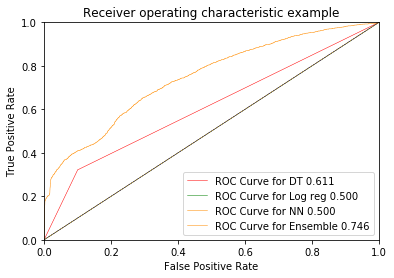

In [63]:
#### ROC

y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)
y_pred_proba_nn = nn_model.predict_proba(X_test)
y_pred_proba_ensemble = voting.predict_proba(X_test_log)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_ensemble = roc_auc_score(y_test_log, y_pred_proba_ensemble[:, 1])


print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)
print("ROC index on voting classifier:", roc_index_ensemble)


fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test, y_pred_proba_ensemble[:,1])


plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), color='darkorange', lw=0.5)
plt.plot(fpr_ensemble, tpr_ensemble, label='ROC Curve for Ensemble {:.3f}'.format(roc_index_ensemble), color='darkorange', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

(b) Score Ranking (or Accuracy Score)

In [64]:
print("Accuracy score on test for DT:", accuracy_score(y_test_log, y_pred_dt))
print("Accuracy score on test for Logistic Regression:", accuracy_score(y_test_log, y_pred_log_reg))
print("Accuracy score on test for NN:", accuracy_score(y_test_log, y_pred_nn))
print("Accuracy score on test for Ensemble:", accuracy_score(y_test_log, y_pred_ensemble))

Accuracy score on test for DT: 0.8348469018725387
Accuracy score on test for Logistic Regression: 0.7552840954753677
Accuracy score on test for NN: 0.8415976854456321
Accuracy score on test for Ensemble: 0.856465482600659


(c) Classification report

In [65]:
print("Report for DT: \n",classification_report(y_test_log, y_pred_dt))
print("\nReport for Logistic Regression: \n",classification_report(y_test_log, y_pred_log_reg))
print("\nReport for NN: \n",classification_report(y_test_log, y_pred_nn))
print("\nReport for Ensemble: \n",classification_report(y_test_log, y_pred_ensemble))

Report for DT: 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     10832
           1       0.16      0.07      0.10      1611

   micro avg       0.83      0.83      0.83     12443
   macro avg       0.52      0.51      0.50     12443
weighted avg       0.78      0.83      0.80     12443


Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10832
           1       0.29      0.61      0.39      1611

   micro avg       0.76      0.76      0.76     12443
   macro avg       0.61      0.69      0.62     12443
weighted avg       0.85      0.76      0.79     12443


Report for NN: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     10832
           1       0.37      0.33      0.35      1611

   micro avg       0.84      0.84      0.84     12443
   macro avg       0.64      0.63      0.63     12443
weig

(d) Output

### b. Do all the models agree on the cars characteristics? How do they vary?

# Task 6. Final Remarks: Decision Making

## 1. Finally, based on all models and analysis, is there

## 2. Can you summarise positives and negatives of each predictive modelling method based on this analysis? 

## 3. How the outcome of this study can be used by decision makers? 